# Binary Classification

The main purpose of this project was to build a Machine Learning models that would detect if retinal image is healthy or diabetic. I used the same  classification models used for the multiclass classificatin task (baseline cnn, VGG16, InceptionV3 , ResNet15V2, InceptionResNetV2 and DenseNet201 model architecture and weights) to train the model for this binary problem. I used accuracy as a metric to justify the model performance.

These classification models are applied to this binary classification task to validate the efficiency of the models

The dataset used in this notebook is subsampled from the dataset used for multiclass task
6000 Healthy Images and 6000 Proliferative Images subsampled dataset was used for binary classification

# Importing Necessary Libraries

In [ ]:
# install the necessary libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from glob import glob
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
from pathlib import Path
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
import matplotlib.image as img
import seaborn as sns
import matplotlib.pyplot as plt
import random
import Augmentor
import PIL
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Data Import and Visualization

In [ ]:
bi_data_dir = "Binary_DR/image"

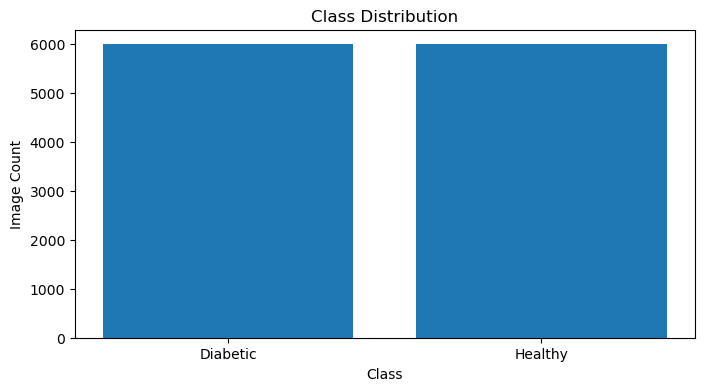

In [ ]:

# Get class names and their respective counts in the downsampled dataset
class_names = os.listdir(bi_data_dir)
class_counts = [len(os.listdir(os.path.join(bi_data_dir, class_name))) for class_name in class_names]

# Plot the distribution
plt.figure(figsize=(8, 4))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.title('Class Distribution')
plt.show()

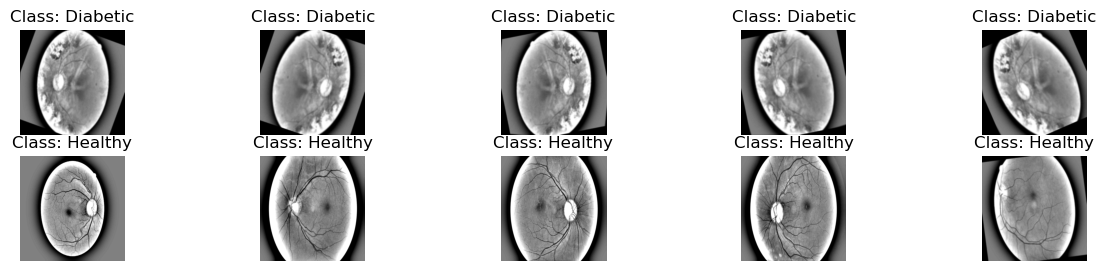

In [ ]:
# Get the list of class names
class_names = sorted(os.listdir(bi_data_dir))

# Set up the plot
plt.figure(figsize=(15, 3))

# Display one grayscale image from each class
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(bi_data_dir, class_name)
    image_names = os.listdir(class_dir)[:5]  # Take the first five images in each class

    # Display the first image in each class
    for j, image_name in enumerate(image_names):
        image_path = os.path.join(class_dir, image_name)

        # Convert the image to grayscale
        img = Image.open(image_path).convert("L")

        # Display the image
        plt.subplot(len(class_names), 5, i * 5 + j + 1)
        plt.imshow(img, cmap="gray")  # Use a grayscale colormap
        plt.axis('off')

        # Set the title as the class label
        plt.title(f'Class: {class_name}')

plt.show()

# Data Preprocessing

In [ ]:
# Initialize lists to store image paths and corresponding labels
image_paths = []
labels = []

# Iterate over each class directory
for class_label in os.listdir(bi_data_dir):
    class_dir = os.path.join(bi_data_dir, class_label)

    # Iterate over each image in the class directory
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        image_paths.append(img_path)
        labels.append(class_label)

In [ ]:
# Convert class labels to integer encoding

label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(labels)

# Convert integer labels to one-hot encoding
one_hot_labels = to_categorical(integer_encoded_labels)

In [ ]:
SIZE = 128
dataset = []
label = []

In [ ]:
# Function to load and resize images from a directory
def load_images_from_directory(directory, target_size=(128, 128)):
    X = []
    y = []
    class_labels = os.listdir(directory)

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, target_size) # Resize the image to a consistent size
            X.append(img)
            y.append(label)

    return np.array(X), np.array(y)

In [ ]:
# Load and resize images from the data directory

X, y = load_images_from_directory(bi_data_dir)

In [ ]:
X.shape

(12000, 128, 128, 3)

In [ ]:
y.shape

(12000,)

In [ ]:
# Normalize pixel values to be between 0 and 1
X_norm = X / 255.0

# Convert class labels to numerical values
class_mapping = {'Healthy': 0, 'Diabetic': 1}
y_numerical = np.array([class_mapping[label] for label in y])

In [ ]:
X_norm.shape

(12000, 128, 128, 3)

In [ ]:
y_numerical.shape

(12000,)

In [ ]:
# Split the resampled dataset into 80% training and 20% validation sets
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_numerical, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(9600, 128, 128, 3)

In [ ]:
X_val.shape

(2400, 128, 128, 3)

In [ ]:
y_train.shape

(9600,)

In [ ]:
y_val.shape

(2400,)

# Define Training Parameters

In [ ]:
mp = ModelCheckpoint('best_seg model.h5', save_best_only = True, monitor = 'val_accuracy')
lrp = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=2)
es = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_accuracy')
call = [lrp, mp, es]

num_classes = 1
img_shape = (128, 128, 3)

metrics = ['accuracy',
           tf.keras.metrics.Recall(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.AUC(name='auc')
          ]

# Build CNN Baseline Model

The model will be initially compiled with Adam optimizer with LR 0.001.

In [ ]:
from tensorflow.keras import layers, models

# Define a simple CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_shape))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=metrics)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 50176)            

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    batch_size = 16,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=call)

Epoch 1/10
600/600 [==============================] - 177s 284ms/step - loss: 0.4220 - accuracy: 0.8134 - recall: 0.8332 - precision: 0.8015 - auc: 0.8883 - val_loss: 0.3634 - val_accuracy: 0.8417 - val_recall: 0.8641 - val_precision: 0.8344 - val_auc: 0.9183 - lr: 0.0010
Epoch 2/10
600/600 [==============================] - 169s 282ms/step - loss: 0.3285 - accuracy: 0.8569 - recall: 0.8499 - precision: 0.8600 - auc: 0.9339 - val_loss: 0.3874 - val_accuracy: 0.8400 - val_recall: 0.7209 - val_precision: 0.9581 - val_auc: 0.9503 - lr: 0.0010
Epoch 3/10
600/600 [==============================] - 127s 211ms/step - loss: 0.2013 - accuracy: 0.9170 - recall: 0.9087 - precision: 0.9228 - auc: 0.9749 - val_loss: 0.1560 - val_accuracy: 0.9383 - val_recall: 0.9102 - val_precision: 0.9682 - val_auc: 0.9854 - lr: 0.0010
Epoch 4/10
600/600 [==============================] - 110s 184ms/step - loss: 0.1253 - accuracy: 0.9516 - recall: 0.9437 - precision: 0.9580 - auc: 0.9896 - val_loss: 0.1369 - val_a

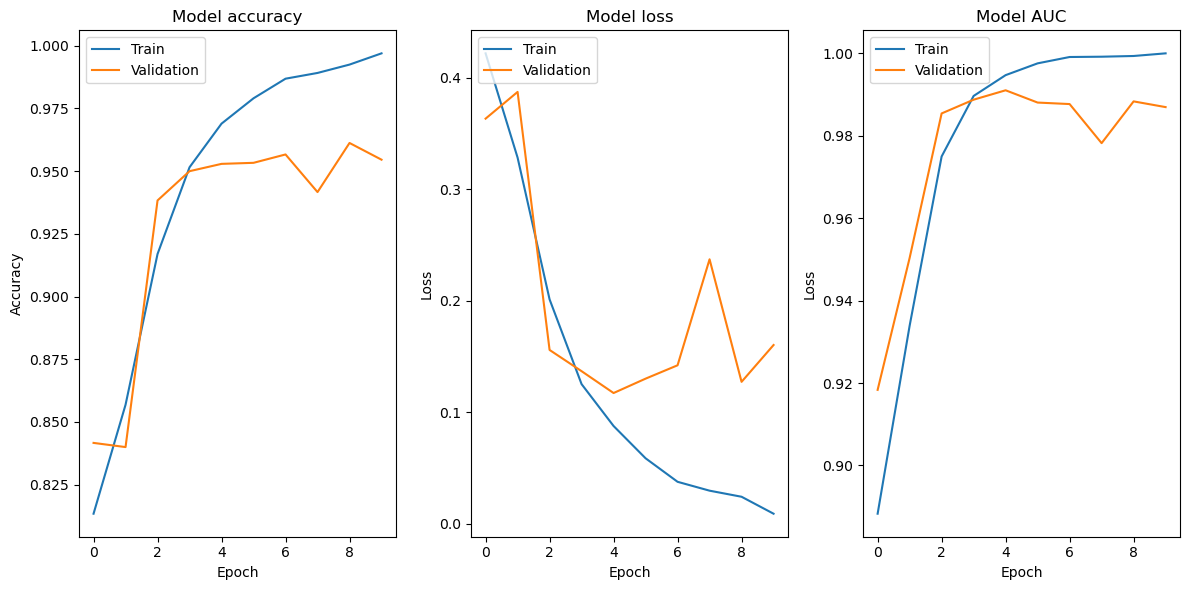

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
h_len = len(history.history['val_loss'])
subset = h_len-1

print("Training Scores:")
print("Accuracy:",history.history['accuracy'][subset])
print("Precision:",history.history['precision'][subset])
print("Recall:",history.history['recall'][subset])
print("AUC:",history.history['auc'][subset])

print("")
print("Validation Scores:")
print("Accuracy:",history.history['val_accuracy'][subset])
print("Precision:",history.history['val_precision'][subset])
print("Recall:",history.history['val_recall'][subset])
print("AUC:",history.history['val_auc'][subset])

Training Scores:
Accuracy: 0.9969791769981384
Precision: 0.9976876378059387
Recall: 0.996221661567688
AUC: 0.999951958656311

Validation Scores:
Accuracy: 0.9545833468437195
Precision: 0.9371606111526489
Recall: 0.9773463010787964
AUC: 0.9869148135185242


75/75 [==============================] - 6s 83ms/step


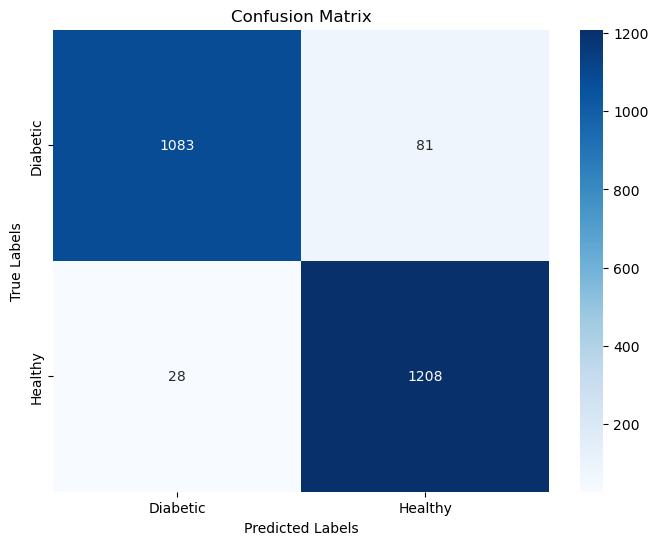

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1164
           1       0.94      0.98      0.96      1236

    accuracy                           0.95      2400
   macro avg       0.96      0.95      0.95      2400
weighted avg       0.96      0.95      0.95      2400



In [ ]:
# Predict the labels on the validation set
y_pred = model.predict(X_val)

# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert one-hot encoded labels to integers
y_val_int = y_val
y_pred_int = y_pred_binary.squeeze()  # Remove any singleton dimensions

# Calculate the confusion matrix
cm = confusion_matrix(y_val_int, y_pred_int)

# Display the confusion matrix with blue colors
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Diabetic', 'Healthy'], yticklabels=['Diabetic', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(y_val_int, y_pred_int)
print("Classification Report:")
print(report)


baseline Model with Adam optimizer and LR 0.001 achieved an accuracy of 95%. The training and validation curve are followed closely without overfitting.
I will change the LR to 0.0005 to determine the best LR for this task

In [ ]:
# Define a simple CNN model
model_ = models.Sequential()
model_.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_shape))
model_.add(layers.MaxPooling2D((2, 2)))

model_.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_.add(layers.MaxPooling2D((2, 2)))

model_.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_.add(layers.Flatten())

model_.add(layers.Dense(64, activation='relu'))
model_.add(Dense(num_classes, activation='sigmoid'))

model_.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=metrics)

model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 50176)             0

In [ ]:
# Train the model
history_ = model_.fit(
    X_train, y_train,
    batch_size = 16,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=call)

Epoch 1/10
600/600 [==============================] - 107s 174ms/step - loss: 0.3930 - accuracy: 0.8260 - recall: 0.8415 - precision: 0.8142 - auc: 0.9051 - val_loss: 0.3464 - val_accuracy: 0.8496 - val_recall: 0.9490 - val_precision: 0.7974 - val_auc: 0.9518 - lr: 5.0000e-04
Epoch 2/10
600/600 [==============================] - 109s 181ms/step - loss: 0.2195 - accuracy: 0.9127 - recall: 0.9114 - precision: 0.9126 - auc: 0.9704 - val_loss: 0.1501 - val_accuracy: 0.9379 - val_recall: 0.9353 - val_precision: 0.9437 - val_auc: 0.9855 - lr: 5.0000e-04
Epoch 3/10
600/600 [==============================] - 109s 181ms/step - loss: 0.1171 - accuracy: 0.9565 - recall: 0.9530 - precision: 0.9590 - auc: 0.9909 - val_loss: 0.1227 - val_accuracy: 0.9525 - val_recall: 0.9466 - val_precision: 0.9606 - val_auc: 0.9899 - lr: 5.0000e-04
Epoch 4/10
600/600 [==============================] - 111s 185ms/step - loss: 0.0904 - accuracy: 0.9674 - recall: 0.9633 - precision: 0.9708 - auc: 0.9943 - val_loss: 0.

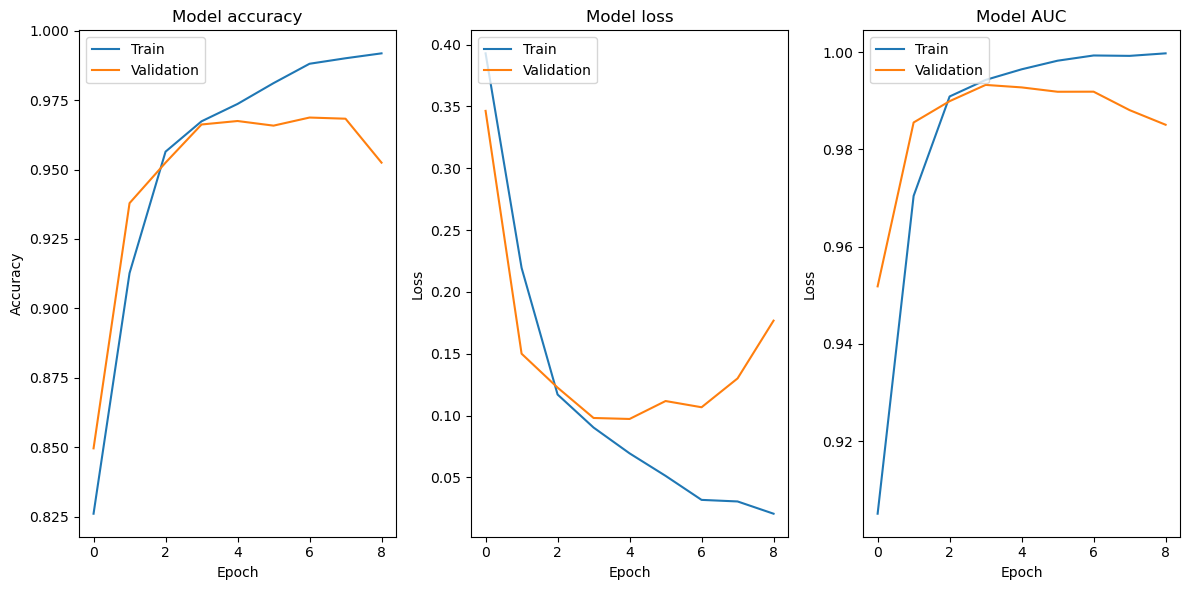

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history_.history['accuracy'])
plt.plot(history_.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history_.history['loss'])
plt.plot(history_.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history_.history['auc'])
plt.plot(history_.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
h_len = len(history_.history['val_loss'])
subset = h_len-1

print("Training Scores:")
print("Accuracy:",history_.history['accuracy'][subset])
print("Precision:",history_.history['precision'][subset])
print("Recall:",history_.history['recall'][subset])
print("AUC:",history_.history['auc'][subset])

print("")
print("Validation Scores:")
print("Accuracy:",history_.history['val_accuracy'][subset])
print("Precision:",history_.history['val_precision'][subset])
print("Recall:",history_.history['val_recall'][subset])
print("AUC:",history_.history['val_auc'][subset])

Training Scores:
Accuracy: 0.9918749928474426
Precision: 0.9932631850242615
Recall: 0.990344226360321
AUC: 0.9997432827949524

Validation Scores:
Accuracy: 0.9524999856948853
Precision: 0.9770408272743225
Recall: 0.9296116232872009
AUC: 0.9850640296936035


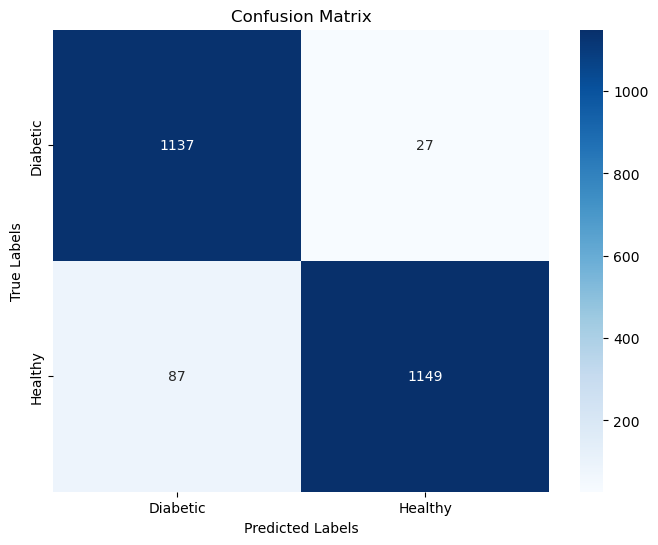

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1164
           1       0.98      0.93      0.95      1236

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.95      0.95      0.95      2400



In [ ]:
# Predict the labels on the validation set
y_pred = model_.predict(X_val)

# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert one-hot encoded labels to integers
y_val_int = y_val
y_pred_int = y_pred_binary.squeeze()  # Remove any singleton dimensions

# Calculate the confusion matrix
cm = confusion_matrix(y_val_int, y_pred_int)

# Display the confusion matrix with blue colors
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Diabetic', 'Healthy'], yticklabels=['Diabetic', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(y_val_int, y_pred_int)
print("Classification Report:")
print(report)


Both LR 0.001 and 0.0005 achieved the same accuracy resullt (95%)

Using RMSProp Optimizer with LR 0.001 to determine the best optimizer

In [ ]:
# Define a simple CNN model
model_rms = models.Sequential()
model_rms.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_shape))
model_rms.add(layers.MaxPooling2D((2, 2)))

model_rms.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_rms.add(layers.MaxPooling2D((2, 2)))

model_rms.add(layers.Conv2D(64, (3, 3), activation='relu'))

model_rms.add(layers.Flatten())
model_rms.add(layers.Dense(64, activation='relu'))
model_rms.add(Dense(num_classes, activation='sigmoid'))

model_rms.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=metrics)

model_rms.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 50176)            

In [ ]:
# Train the model
history_rms = model_rms.fit(
    X_train, y_train,
    batch_size = 16,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=call)

Epoch 1/10
600/600 [==============================] - 171s 277ms/step - loss: 0.4531 - accuracy: 0.8031 - recall: 0.8413 - precision: 0.8275 - auc: 0.9086 - val_loss: 0.3608 - val_accuracy: 0.8508 - val_recall: 0.8172 - val_precision: 0.8844 - val_auc: 0.9288 - lr: 0.0010
Epoch 2/10
600/600 [==============================] - 165s 275ms/step - loss: 0.3203 - accuracy: 0.8642 - recall: 0.8556 - precision: 0.8687 - auc: 0.9376 - val_loss: 0.2843 - val_accuracy: 0.8879 - val_recall: 0.8325 - val_precision: 0.9432 - val_auc: 0.9585 - lr: 0.0010
Epoch 3/10
600/600 [==============================] - 168s 280ms/step - loss: 0.2468 - accuracy: 0.8993 - recall: 0.8917 - precision: 0.9040 - auc: 0.9629 - val_loss: 0.2773 - val_accuracy: 0.8988 - val_recall: 0.8390 - val_precision: 0.9593 - val_auc: 0.9670 - lr: 0.0010
Epoch 4/10
600/600 [==============================] - 167s 279ms/step - loss: 0.1759 - accuracy: 0.9320 - recall: 0.9267 - precision: 0.9356 - auc: 0.9804 - val_loss: 0.1727 - val_a

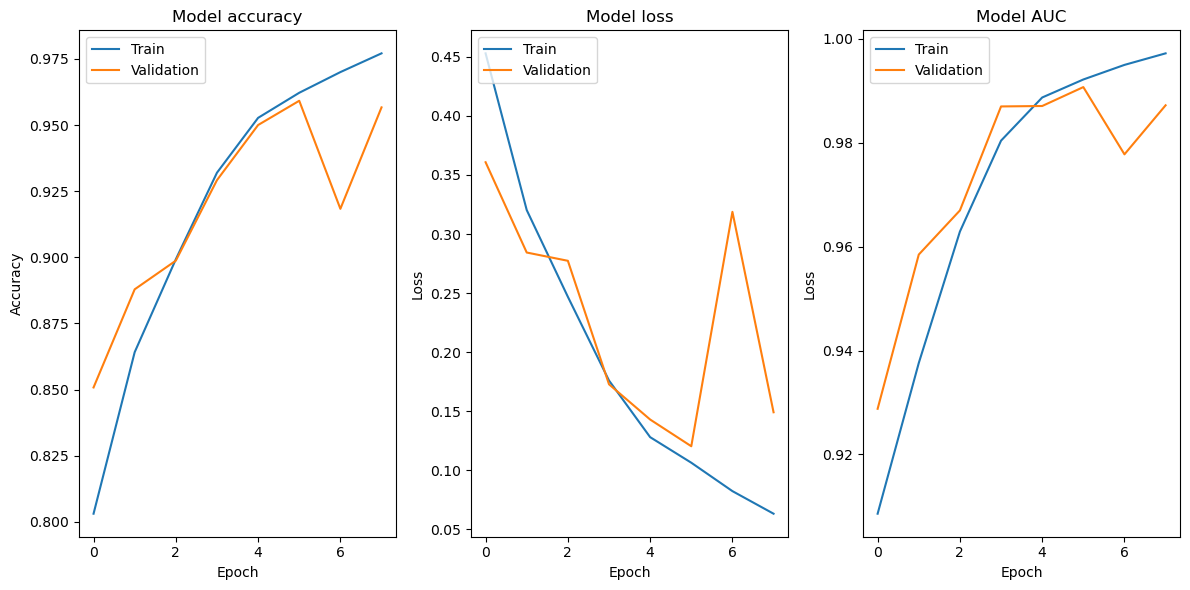

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history_rms.history['accuracy'])
plt.plot(history_rms.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history_rms.history['loss'])
plt.plot(history_rms.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history_rms.history['auc'])
plt.plot(history_rms.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
h_len = len(history_rms.history['val_loss'])
subset = h_len-1

print("Training Scores:")
print("Accuracy:",history_rms.history['accuracy'][subset])
print("Precision:",history_rms.history['precision'][subset])
print("Recall:",history_rms.history['recall'][subset])
print("AUC:",history_rms.history['auc'][subset])

print("")
print("Validation Scores:")
print("Accuracy:",history_rms.history['val_accuracy'][subset])
print("Precision:",history_rms.history['val_precision'][subset])
print("Recall:",history_rms.history['val_recall'][subset])
print("AUC:",history_rms.history['val_auc'][subset])

Training Scores:
Accuracy: 0.9770833253860474
Precision: 0.9785172939300537
Recall: 0.975230872631073
AUC: 0.9972141981124878

Validation Scores:
Accuracy: 0.9566666483879089
Precision: 0.9788494110107422
Recall: 0.9360841512680054
AUC: 0.9872152209281921


75/75 [==============================] - 10s 135ms/step


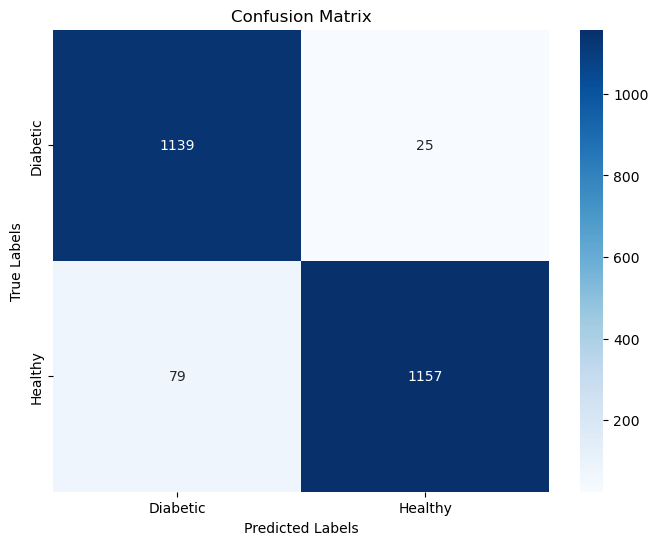

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1164
           1       0.98      0.94      0.96      1236

    accuracy                           0.96      2400
   macro avg       0.96      0.96      0.96      2400
weighted avg       0.96      0.96      0.96      2400



In [ ]:
# Predict the labels on the validation set
y_pred = model_rms.predict(X_val)

# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert one-hot encoded labels to integers
y_val_int = y_val
y_pred_int = y_pred_binary.squeeze()  # Remove any singleton dimensions

# Calculate the confusion matrix
cm = confusion_matrix(y_val_int, y_pred_int)

# Display the confusion matrix with blue colors
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Diabetic', 'Healthy'], yticklabels=['Diabetic', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(y_val_int, y_pred_int)
print("Classification Report:")
print(report)

RMSprop optimizer improved by 1%

using SGD Optimizer

In [ ]:
from tensorflow.keras.optimizers import SGD

model_sgd = models.Sequential()
model_sgd.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_shape))
model_sgd.add(layers.MaxPooling2D((2, 2)))

model_sgd.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_sgd.add(layers.MaxPooling2D((2, 2)))

model_sgd.add(layers.Conv2D(64, (3, 3), activation='relu'))

model_sgd.add(layers.Flatten())
model_sgd.add(layers.Dense(64, activation='relu'))
model_sgd.add(Dense(num_classes, activation='sigmoid'))

model_sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=metrics)

model_sgd.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 50176)            

In [ ]:
# Train the model
history_sgd = model_sgd.fit(
    X_train, y_train,
    batch_size = 16,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=call)

Epoch 1/10
600/600 [==============================] - 166s 272ms/step - loss: 0.6633 - accuracy: 0.6941 - recall: 0.7898 - precision: 0.7270 - auc: 0.8282 - val_loss: 0.6283 - val_accuracy: 0.7183 - val_recall: 0.6019 - val_precision: 0.8017 - val_auc: 0.8202 - lr: 0.0010
Epoch 2/10
600/600 [==============================] - 161s 268ms/step - loss: 0.5684 - accuracy: 0.7704 - recall: 0.8163 - precision: 0.7453 - auc: 0.8203 - val_loss: 0.5098 - val_accuracy: 0.7842 - val_recall: 0.8908 - val_precision: 0.7419 - val_auc: 0.8397 - lr: 0.0010
Epoch 3/10
600/600 [==============================] - 159s 264ms/step - loss: 0.4960 - accuracy: 0.7836 - recall: 0.8168 - precision: 0.7637 - auc: 0.8374 - val_loss: 0.4798 - val_accuracy: 0.7912 - val_recall: 0.7848 - val_precision: 0.8050 - val_auc: 0.8519 - lr: 0.0010
Epoch 4/10
600/600 [==============================] - 158s 263ms/step - loss: 0.4708 - accuracy: 0.7959 - recall: 0.8220 - precision: 0.7790 - auc: 0.8537 - val_loss: 0.4849 - val_a

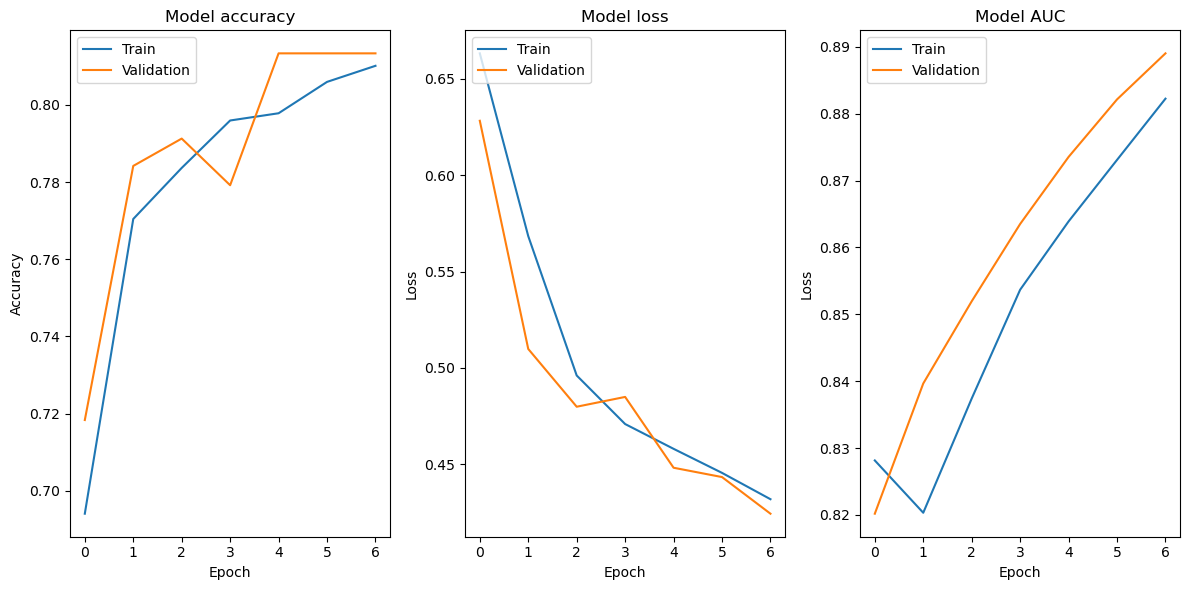

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history_sgd.history['accuracy'])
plt.plot(history_sgd.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history_sgd.history['loss'])
plt.plot(history_sgd.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history_sgd.history['auc'])
plt.plot(history_sgd.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
h_len = len(history_sgd.history['val_loss'])
subset = h_len-1

print("Training Scores:")
print("Accuracy:",history_sgd.history['accuracy'][subset])
print("Precision:",history_sgd.history['precision'][subset])
print("Recall:",history_sgd.history['recall'][subset])
print("AUC:",history_sgd.history['auc'][subset])

print("")
print("Validation Scores:")
print("Accuracy:",history_sgd.history['val_accuracy'][subset])
print("Precision:",history_sgd.history['val_precision'][subset])
print("Recall:",history_sgd.history['val_recall'][subset])
print("AUC:",history_sgd.history['val_auc'][subset])

Training Scores:
Accuracy: 0.8101041913032532
Precision: 0.7976118326187134
Recall: 0.8272460103034973
AUC: 0.8822360634803772

Validation Scores:
Accuracy: 0.8133333325386047
Precision: 0.8240131735801697
Recall: 0.8106796145439148
AUC: 0.8890122771263123


75/75 [==============================] - 10s 123ms/step


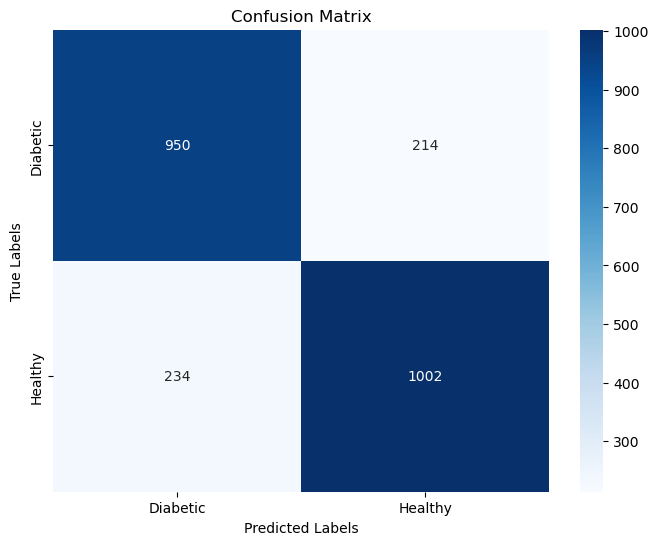

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1164
           1       0.82      0.81      0.82      1236

    accuracy                           0.81      2400
   macro avg       0.81      0.81      0.81      2400
weighted avg       0.81      0.81      0.81      2400



In [ ]:
# Predict the labels on the validation set
y_pred = model_sgd.predict(X_val)

# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert one-hot encoded labels to integers
y_val_int = y_val
y_pred_int = y_pred_binary.squeeze()  # Remove any singleton dimensions

# Calculate the confusion matrix
cm = confusion_matrix(y_val_int, y_pred_int)

# Display the confusion matrix with blue colors
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Diabetic', 'Healthy'], yticklabels=['Diabetic', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(y_val_int, y_pred_int)
print("Classification Report:")
print(report)


RMSprop performed better so will modify the learning rate to get the best LR for the model

In [ ]:
# Define a simple CNN model
model_rms2 = models.Sequential()
model_rms2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_shape))
model_rms2.add(layers.MaxPooling2D((2, 2)))

model_rms2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_rms2.add(layers.MaxPooling2D((2, 2)))

model_rms2.add(layers.Conv2D(64, (3, 3), activation='relu'))

model_rms2.add(layers.Flatten())
model_rms2.add(layers.Dense(64, activation='relu'))
model_rms2.add(Dense(num_classes, activation='sigmoid'))

model_rms2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005), loss='binary_crossentropy', metrics=metrics)

model_rms2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 flatten_4 (Flatten)         (None, 50176)            

In [ ]:
# Train the model
history_rms2 = model_rms2.fit(
    X_train, y_train,
    batch_size = 16,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=call)

Epoch 1/10
600/600 [==============================] - 165s 269ms/step - loss: 0.4276 - accuracy: 0.8149 - recall: 0.8735 - precision: 0.8230 - auc: 0.9167 - val_loss: 0.3576 - val_accuracy: 0.8525 - val_recall: 0.7638 - val_precision: 0.9384 - val_auc: 0.9436 - lr: 5.0000e-04
Epoch 2/10
600/600 [==============================] - 168s 279ms/step - loss: 0.2544 - accuracy: 0.8965 - recall: 0.8984 - precision: 0.8935 - auc: 0.9605 - val_loss: 0.1821 - val_accuracy: 0.9258 - val_recall: 0.9547 - val_precision: 0.9063 - val_auc: 0.9819 - lr: 5.0000e-04
Epoch 3/10
600/600 [==============================] - 170s 283ms/step - loss: 0.1556 - accuracy: 0.9396 - recall: 0.9379 - precision: 0.9402 - auc: 0.9845 - val_loss: 0.1235 - val_accuracy: 0.9558 - val_recall: 0.9466 - val_precision: 0.9669 - val_auc: 0.9895 - lr: 5.0000e-04
Epoch 4/10
600/600 [==============================] - 167s 278ms/step - loss: 0.1158 - accuracy: 0.9567 - recall: 0.9528 - precision: 0.9596 - auc: 0.9908 - val_loss: 0.

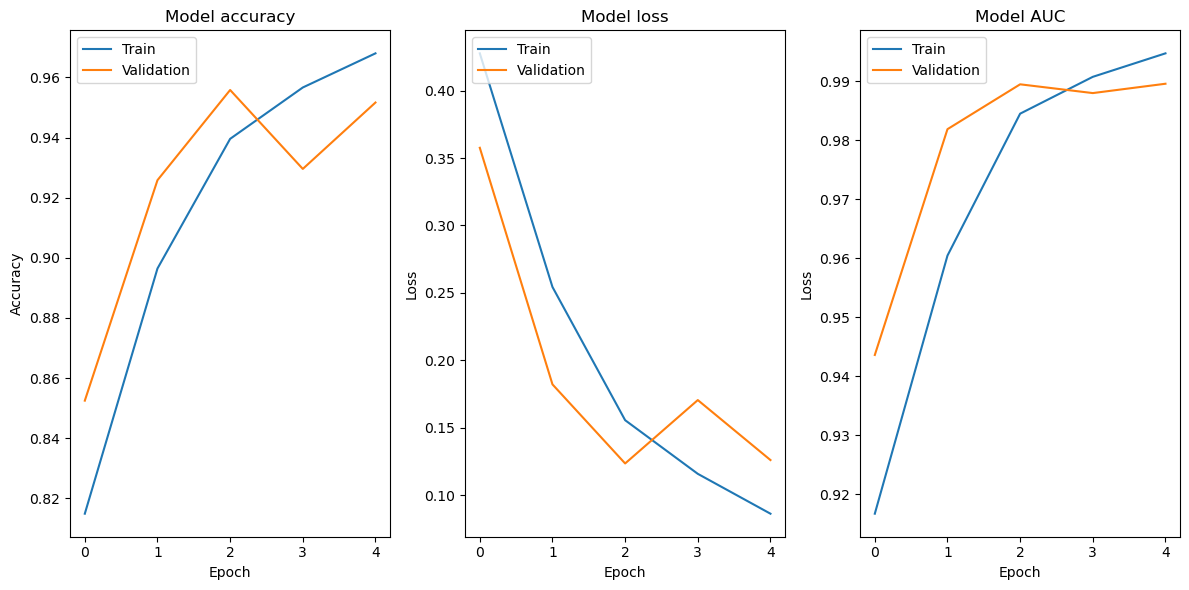

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history_rms2.history['accuracy'])
plt.plot(history_rms2.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history_rms2.history['loss'])
plt.plot(history_rms2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history_rms2.history['auc'])
plt.plot(history_rms2.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
h_len = len(history_rms2.history['val_loss'])
subset = h_len-1

print("Training Scores:")
print("Accuracy:",history_rms2.history['accuracy'][subset])
print("Precision:",history_rms2.history['precision'][subset])
print("Recall:",history_rms2.history['recall'][subset])
print("AUC:",history_rms2.history['auc'][subset])

print("")
print("Validation Scores:")
print("Accuracy:",history_rms2.history['val_accuracy'][subset])
print("Precision:",history_rms2.history['val_precision'][subset])
print("Recall:",history_rms2.history['val_recall'][subset])
print("AUC:",history_rms2.history['val_auc'][subset])

Training Scores:
Accuracy: 0.9680208563804626
Precision: 0.9692566990852356
Recall: 0.9662048816680908
AUC: 0.9947493672370911

Validation Scores:
Accuracy: 0.9516666531562805
Precision: 0.9437400698661804
Recall: 0.9635922312736511
AUC: 0.9895979166030884


75/75 [==============================] - 9s 120ms/step


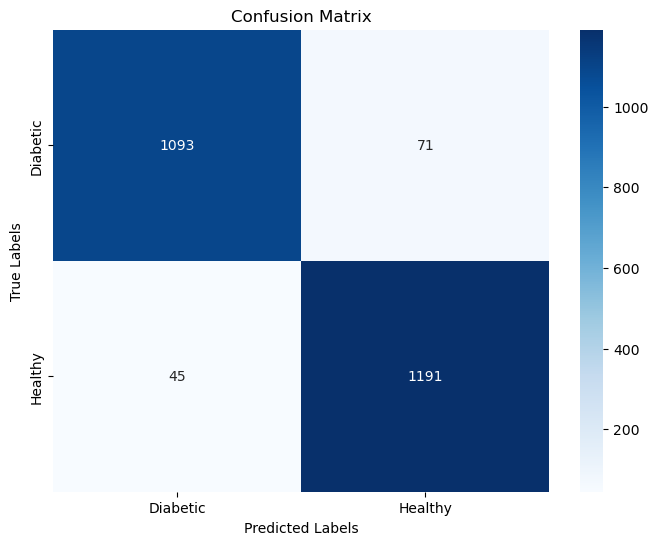

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1164
           1       0.94      0.96      0.95      1236

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.95      0.95      0.95      2400



In [ ]:
# Predict the labels on the validation set
y_pred = model_rms2.predict(X_val)

# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert one-hot encoded labels to integers
y_val_int = y_val
y_pred_int = y_pred_binary.squeeze()  # Remove any singleton dimensions

# Calculate the confusion matrix
cm = confusion_matrix(y_val_int, y_pred_int)

# Display the confusion matrix with blue colors
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Diabetic', 'Healthy'], yticklabels=['Diabetic', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(y_val_int, y_pred_int)
print("Classification Report:")
print(report)


After training the baseline cnn model with different parameters, RMSprop optimier with LR 0.001 performed better achiving an accuracy of 96%
This parameters will now be applied to the pretrained models

# Transfer Learning Approach for Binary Classification

In [ ]:
# Load the pre-trained VGG16 model without the top (fully connected) layers
vgg_bi_base = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the weights of the pre-trained layers
for layer in vgg_bi_base.layers:
    layer.trainable = False

# Create a new model by adding your layers on top of the pre-trained model
model_bi_vgg = models.Sequential()
model_bi_vgg.add(vgg_bi_base)

# Add your own layers on top of the VGG16 base
model_bi_vgg.add(Flatten())
model_bi_vgg.add(Dense(512, activation="relu"))
model_bi_vgg.add(Dropout(0.5))
model_bi_vgg.add(Dense(256, activation="relu"))
model_bi_vgg.add(Dropout(0.5))
model_bi_vgg.add(Dense(1, activation="sigmoid"))

# Compile the model
model_bi_vgg.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=metrics)

# Print the model summary
model_bi_vgg.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                

In [ ]:
# Train the model
history_bi_vgg = model_bi_vgg.fit(
    X_train, y_train,
    batch_size = 16,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=call)

Epoch 1/10
600/600 [==============================] - 796s 1s/step - loss: 0.2986 - accuracy: 0.9048 - recall: 0.9195 - precision: 0.8703 - auc: 0.9587 - val_loss: 0.1302 - val_accuracy: 0.9483 - val_recall: 0.9175 - val_precision: 0.9810 - val_auc: 0.9902 - lr: 0.0010
Epoch 2/10
600/600 [==============================] - 757s 1s/step - loss: 0.1683 - accuracy: 0.9430 - recall: 0.9362 - precision: 0.9483 - auc: 0.9828 - val_loss: 0.2237 - val_accuracy: 0.9317 - val_recall: 0.8714 - val_precision: 0.9954 - val_auc: 0.9851 - lr: 0.0010
Epoch 3/10
600/600 [==============================] - 547s 912ms/step - loss: 0.1533 - accuracy: 0.9517 - recall: 0.9456 - precision: 0.9565 - auc: 0.9851 - val_loss: 0.1020 - val_accuracy: 0.9646 - val_recall: 0.9571 - val_precision: 0.9737 - val_auc: 0.9927 - lr: 0.0010
Epoch 4/10
600/600 [==============================] - 555s 925ms/step - loss: 0.1411 - accuracy: 0.9550 - recall: 0.9463 - precision: 0.9624 - auc: 0.9864 - val_loss: 0.1244 - val_accurac

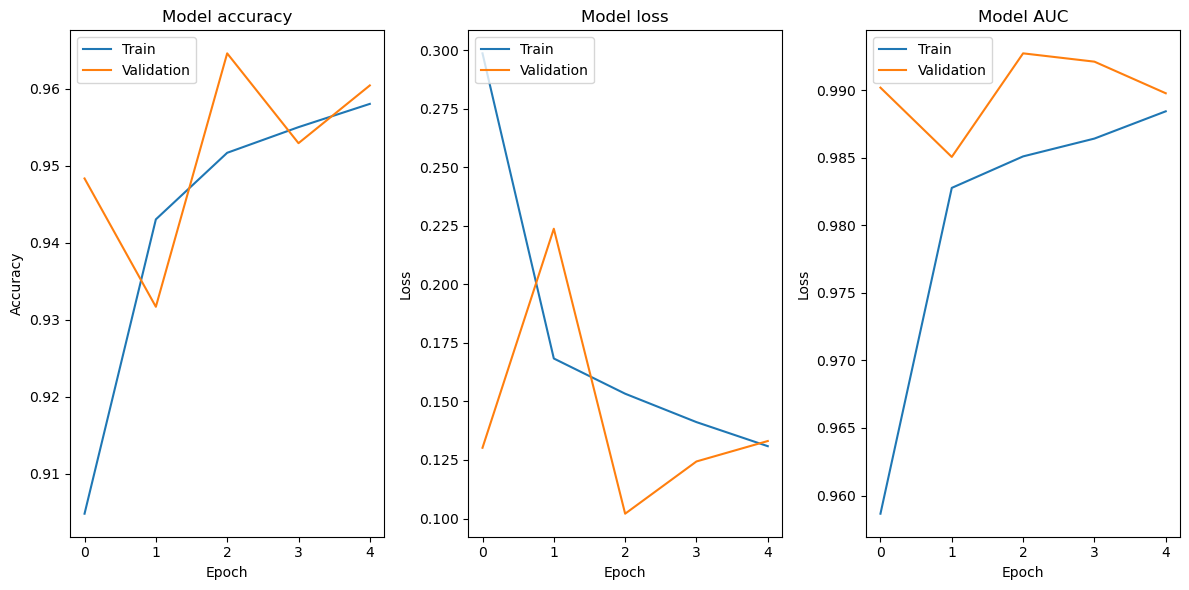

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history_bi_vgg.history['accuracy'])
plt.plot(history_bi_vgg.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history_bi_vgg.history['loss'])
plt.plot(history_bi_vgg.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history_bi_vgg.history['auc'])
plt.plot(history_bi_vgg.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
h_len = len(history_bi_vgg.history['val_loss'])
subset = h_len-1

print("Training Scores:")
print("Accuracy:",history_bi_vgg.history['accuracy'][subset])
print("Precision:",history_bi_vgg.history['precision'][subset])
print("Recall:",history_bi_vgg.history['recall'][subset])
print("AUC:",history_bi_vgg.history['auc'][subset])

print("")
print("Validation Scores:")
print("Accuracy:",history_bi_vgg.history['val_accuracy'][subset])
print("Precision:",history_bi_vgg.history['val_precision'][subset])
print("Recall:",history_bi_vgg.history['val_recall'][subset])
print("AUC:",history_bi_vgg.history['val_auc'][subset])

Training Scores:
Accuracy: 0.958020806312561
Precision: 0.9630494713783264
Recall: 0.9519311785697937
AUC: 0.9884439706802368

Validation Scores:
Accuracy: 0.9604166746139526
Precision: 0.9871904253959656
Recall: 0.9352750778198242
AUC: 0.9897806644439697


75/75 [==============================] - 201s 3s/step


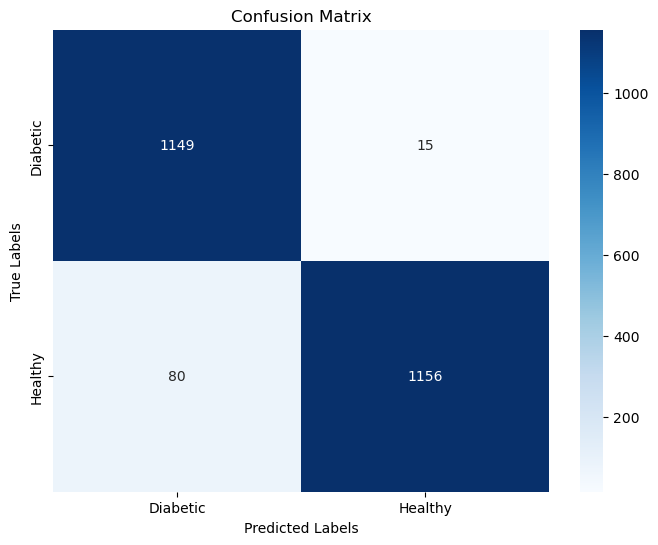

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1164
           1       0.99      0.94      0.96      1236

    accuracy                           0.96      2400
   macro avg       0.96      0.96      0.96      2400
weighted avg       0.96      0.96      0.96      2400



In [ ]:
# Predict the labels on the validation set
y_pred = model_bi_vgg.predict(X_val)

# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert one-hot encoded labels to integers
y_val_int = y_val
y_pred_int = y_pred_binary.squeeze()  # Remove any singleton dimensions

# Calculate the confusion matrix
cm = confusion_matrix(y_val_int, y_pred_int)

# Display the confusion matrix with blue colors
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Diabetic', 'Healthy'], yticklabels=['Diabetic', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(y_val_int, y_pred_int)
print("Classification Report:")
print(report)


# Inceptionv3 - Binary Classification

In [ ]:
# Load the pre-trained VGG16 model without the top (fully connected) layers
bi_model_incptn = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the weights of the pre-trained layers
for layer in bi_model_incptn.layers:
    layer.trainable = False

# Create a new model by adding your layers on top of the pre-trained model
model_bi_incptnv3 = models.Sequential()
model_bi_incptnv3.add(bi_model_incptn)

# Add your own layers on top of the VGG16 base
model_bi_incptnv3.add(Flatten())
model_bi_incptnv3.add(Dense(512, activation="relu"))
model_bi_incptnv3.add(Dropout(0.5))
model_bi_incptnv3.add(Dense(256, activation="relu"))
model_bi_incptnv3.add(Dropout(0.5))
model_bi_incptnv3.add(Dense(1, activation="sigmoid"))

# Compile the model
model_bi_incptnv3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=metrics)

# Print the model summary
model_bi_incptnv3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 1)                

In [ ]:
# Train the model
history_bi_Incptn = model_bi_incptnv3.fit(
    X_train, y_train,
    batch_size = 16,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=call)

Epoch 1/10
600/600 [==============================] - 387s 580ms/step - loss: 1.1763 - accuracy: 0.8728 - recall: 0.8835 - precision: 0.8957 - auc: 0.9321 - val_loss: 0.2430 - val_accuracy: 0.9187 - val_recall: 0.8568 - val_precision: 0.9833 - val_auc: 0.9800 - lr: 0.0010
Epoch 2/10
600/600 [==============================] - 343s 572ms/step - loss: 0.2778 - accuracy: 0.9205 - recall: 0.9118 - precision: 0.9268 - auc: 0.9680 - val_loss: 0.3433 - val_accuracy: 0.9146 - val_recall: 0.9798 - val_precision: 0.8706 - val_auc: 0.9720 - lr: 0.0010
Epoch 3/10
600/600 [==============================] - 324s 540ms/step - loss: 0.2214 - accuracy: 0.9333 - recall: 0.9270 - precision: 0.9380 - auc: 0.9767 - val_loss: 0.1403 - val_accuracy: 0.9458 - val_recall: 0.9409 - val_precision: 0.9533 - val_auc: 0.9888 - lr: 0.0010
Epoch 4/10
600/600 [==============================] - 327s 546ms/step - loss: 0.1844 - accuracy: 0.9453 - recall: 0.9360 - precision: 0.9530 - auc: 0.9818 - val_loss: 0.1546 - val_a

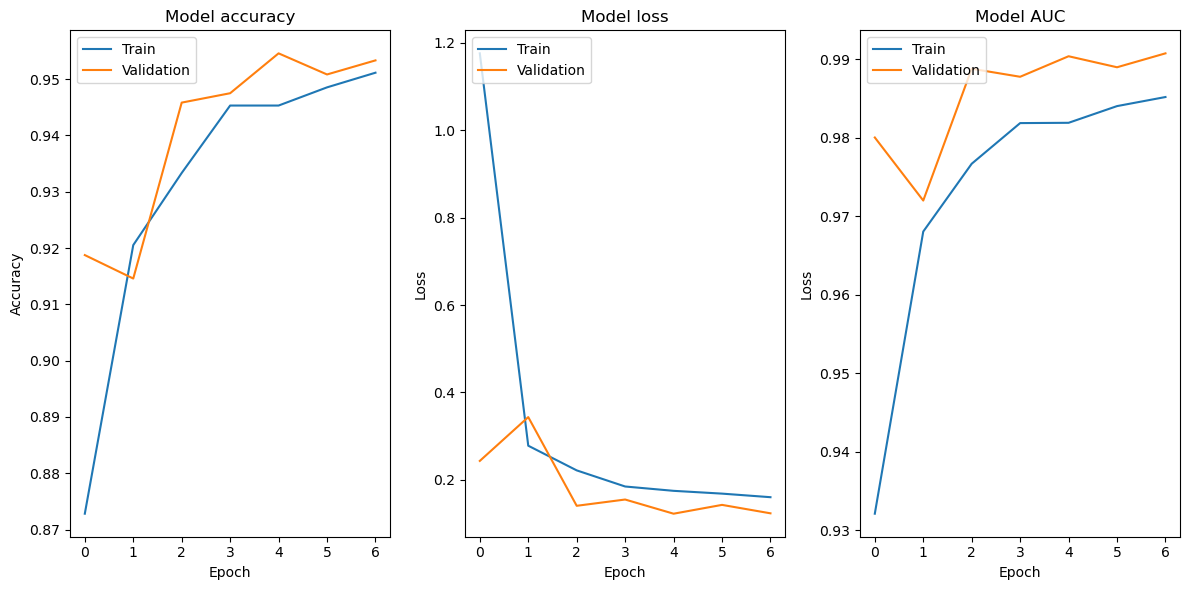

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history_bi_Incptn.history['accuracy'])
plt.plot(history_bi_Incptn.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history_bi_Incptn.history['loss'])
plt.plot(history_bi_Incptn.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history_bi_Incptn.history['auc'])
plt.plot(history_bi_Incptn.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
h_len = len(history_bi_Incptn.history['val_loss'])
subset = h_len-1

print("Training Scores:")
print("Accuracy:",history_bi_Incptn.history['accuracy'][subset])
print("Precision:",history_bi_Incptn.history['precision'][subset])
print("Recall:",history_bi_Incptn.history['recall'][subset])
print("AUC:",history_bi_Incptn.history['auc'][subset])

print("")
print("Validation Scores:")
print("Accuracy:",history_bi_Incptn.history['val_accuracy'][subset])
print("Precision:",history_bi_Incptn.history['val_precision'][subset])
print("Recall:",history_bi_Incptn.history['val_recall'][subset])
print("AUC:",history_bi_Incptn.history['val_auc'][subset])

Training Scores:
Accuracy: 0.9511458277702332
Precision: 0.956235408782959
Recall: 0.9447942972183228
AUC: 0.985168993473053

Validation Scores:
Accuracy: 0.95333331823349
Precision: 0.9561688303947449
Recall: 0.9530744552612305
AUC: 0.9907322525978088


75/75 [==============================] - 36s 387ms/step


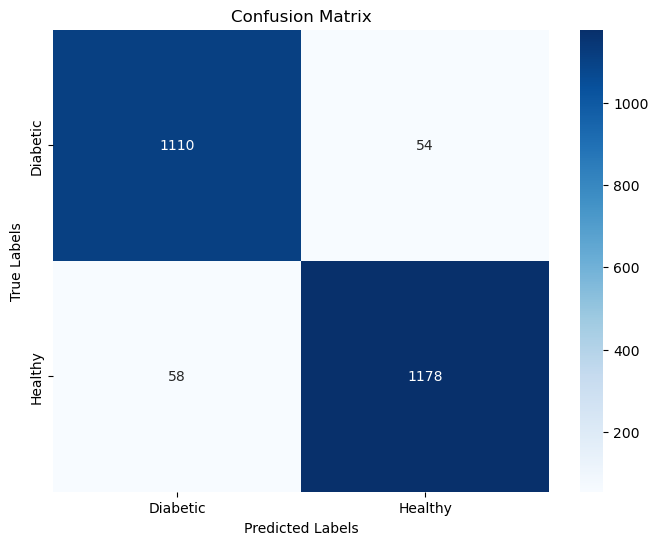

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1164
           1       0.96      0.95      0.95      1236

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.95      0.95      0.95      2400



In [ ]:
# Predict the labels on the validation set
y_pred = model_bi_incptnv3.predict(X_val)

# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert one-hot encoded labels to integers
y_val_int = y_val
y_pred_int = y_pred_binary.squeeze()  # Remove any singleton dimensions

# Calculate the confusion matrix
cm = confusion_matrix(y_val_int, y_pred_int)

# Display the confusion matrix with blue colors
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Diabetic', 'Healthy'], yticklabels=['Diabetic', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(y_val_int, y_pred_int)
print("Classification Report:")
print(report)


# ResNet

In [ ]:
bi_model_res = tf.keras.applications.ResNet152V2(input_shape=img_shape,include_top=False,weights="imagenet")

# Freeze the weights of the pre-trained layers
for layer in bi_model_res.layers:
    layer.trainable = False

# Create a new model by adding your layers on top of the pre-trained model
model_bi_res = models.Sequential()
model_bi_res.add(bi_model_res)

# Add your own layers on top of the VGG16 base
model_bi_res.add(Flatten())
model_bi_res.add(Dense(512, activation="relu"))
model_bi_res.add(Dropout(0.5))
model_bi_res.add(Dense(256, activation="relu"))
model_bi_res.add(Dropout(0.5))
model_bi_res.add(Dense(1, activation="sigmoid"))

# Compile the model
model_bi_res.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=metrics)

# Print the model summary
model_bi_res.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 flatten_9 (Flatten)         (None, 32768)             0         
                                                                 
 dense_23 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 1)               

In [ ]:
# Train the model
history_bi_res = model_bi_res.fit(
    X_train, y_train,
    batch_size = 16,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=call)

Epoch 1/10
600/600 [==============================] - 857s 1s/step - loss: 1.8073 - accuracy: 0.8938 - recall: 0.9053 - precision: 0.9059 - auc: 0.9322 - val_loss: 0.2713 - val_accuracy: 0.9350 - val_recall: 0.8835 - val_precision: 0.9891 - val_auc: 0.9795 - lr: 0.0010
Epoch 2/10
600/600 [==============================] - 1625s 3s/step - loss: 0.3333 - accuracy: 0.9339 - recall: 0.9295 - precision: 0.9367 - auc: 0.9687 - val_loss: 0.1884 - val_accuracy: 0.9371 - val_recall: 0.9838 - val_precision: 0.9027 - val_auc: 0.9881 - lr: 0.0010
Epoch 3/10
600/600 [==============================] - 927s 2s/step - loss: 0.2433 - accuracy: 0.9442 - recall: 0.9419 - precision: 0.9454 - auc: 0.9786 - val_loss: 0.1141 - val_accuracy: 0.9625 - val_recall: 0.9409 - val_precision: 0.9856 - val_auc: 0.9923 - lr: 0.0010
Epoch 4/10
600/600 [==============================] - 1690s 3s/step - loss: 0.1936 - accuracy: 0.9542 - recall: 0.9486 - precision: 0.9586 - auc: 0.9835 - val_loss: 0.1012 - val_accuracy: 0

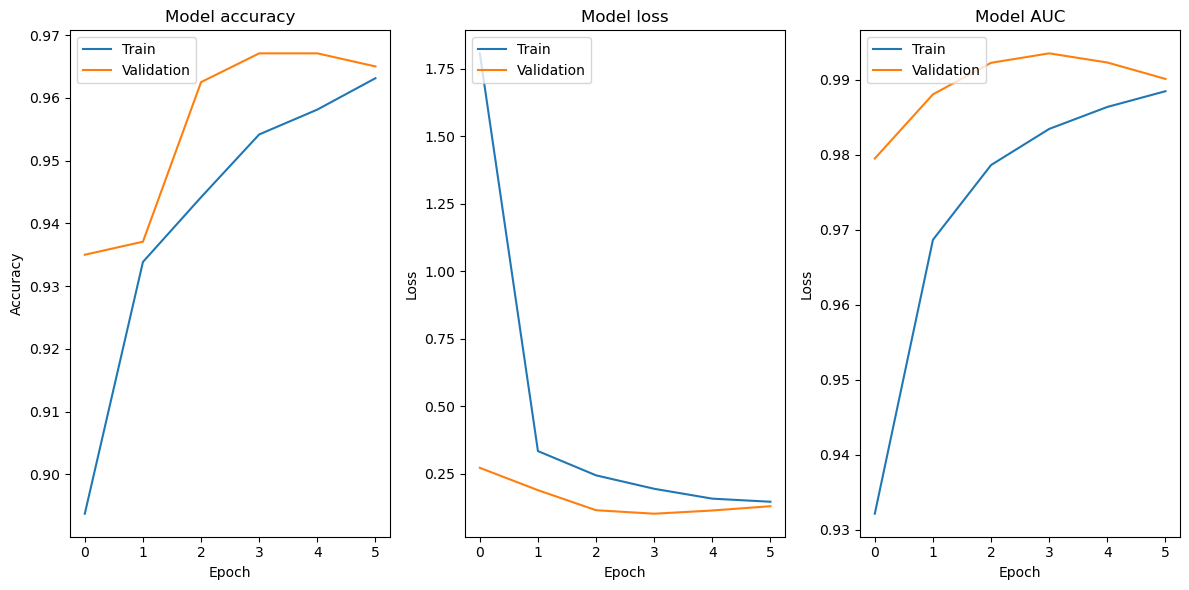

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history_bi_res.history['accuracy'])
plt.plot(history_bi_res.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history_bi_res.history['loss'])
plt.plot(history_bi_res.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history_bi_res.history['auc'])
plt.plot(history_bi_res.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
h_len = len(history_bi_res.history['val_loss'])
subset = h_len-1

print("Training Scores:")
print("Accuracy:",history_bi_res.history['accuracy'][subset])
print("Precision:",history_bi_res.history['precision'][subset])
print("Recall:",history_bi_res.history['recall'][subset])
print("AUC:",history_bi_res.history['auc'][subset])

print("")
print("Validation Scores:")
print("Accuracy:",history_bi_res.history['val_accuracy'][subset])
print("Precision:",history_bi_res.history['val_precision'][subset])
print("Recall:",history_bi_res.history['val_recall'][subset])
print("AUC:",history_bi_res.history['val_auc'][subset])

Training Scores:
Accuracy: 0.9631249904632568
Precision: 0.9667654633522034
Recall: 0.9586482048034668
AUC: 0.9884770512580872

Validation Scores:
Accuracy: 0.9649999737739563
Precision: 0.9897959232330322
Recall: 0.9417475461959839
AUC: 0.9901167154312134


75/75 [==============================] - 460s 5s/step


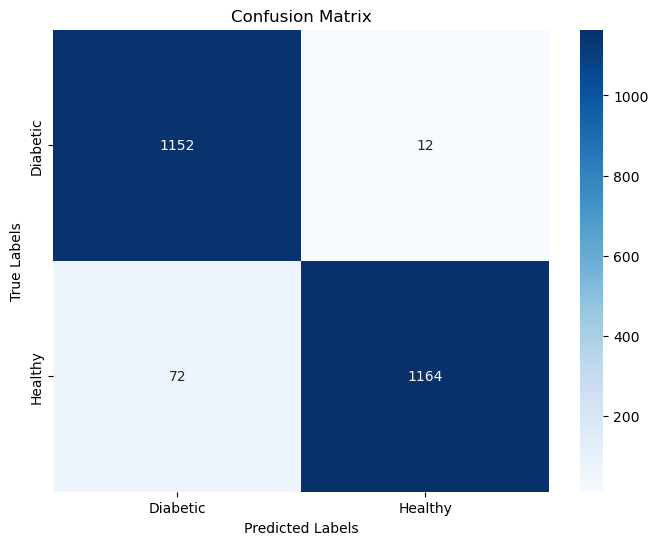

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1164
           1       0.99      0.94      0.97      1236

    accuracy                           0.96      2400
   macro avg       0.97      0.97      0.96      2400
weighted avg       0.97      0.96      0.97      2400



In [ ]:
# Predict the labels on the validation set
y_pred = model_bi_res.predict(X_val)

# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert one-hot encoded labels to integers
y_val_int = y_val
y_pred_int = y_pred_binary.squeeze()  # Remove any singleton dimensions

# Calculate the confusion matrix
cm = confusion_matrix(y_val_int, y_pred_int)

# Display the confusion matrix with blue colors
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Diabetic', 'Healthy'], yticklabels=['Diabetic', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(y_val_int, y_pred_int)
print("Classification Report:")
print(report)


# InceptionResNetV2

In [ ]:
bi_model_incptnres = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the weights of the pre-trained layers
for layer in bi_model_incptnres.layers:
    layer.trainable = False

# Create a new model by adding your layers on top of the pre-trained model
model_Incptnres = models.Sequential()
model_Incptnres.add(bi_model_incptnres)

# Add your own layers on top of the VGG16 base
model_Incptnres.add(Flatten())
model_Incptnres.add(Dense(512, activation="relu"))
model_Incptnres.add(Dropout(0.5))
model_Incptnres.add(Dense(256, activation="relu"))
model_Incptnres.add(Dropout(0.5))
model_Incptnres.add(Dense(1, activation="sigmoid"))

# Compile the model
model_Incptnres.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=metrics)

# Print the model summary
model_Incptnres.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 2, 2, 1536)        54336736  
 ional)                                                          
                                                                 
 flatten_11 (Flatten)        (None, 6144)              0         
                                                                 
 dense_29 (Dense)            (None, 512)               3146240   
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 256)               131328    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                     

In [ ]:
history_Incptnres = model_Incptnres.fit(
    X_train, y_train,
    batch_size = 16,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=call)

Epoch 1/10
600/600 [==============================] - 1378s 2s/step - loss: 1.1471 - accuracy: 0.8403 - recall: 0.8563 - precision: 0.8719 - auc: 0.9163 - val_loss: 0.2749 - val_accuracy: 0.9025 - val_recall: 0.8228 - val_precision: 0.9855 - val_auc: 0.9690 - lr: 0.0010
Epoch 2/10
600/600 [==============================] - 1099s 2s/step - loss: 0.2969 - accuracy: 0.9110 - recall: 0.8997 - precision: 0.9193 - auc: 0.9615 - val_loss: 0.1564 - val_accuracy: 0.9442 - val_recall: 0.9296 - val_precision: 0.9607 - val_auc: 0.9846 - lr: 0.0010
Epoch 3/10
600/600 [==============================] - 1007s 2s/step - loss: 0.2264 - accuracy: 0.9291 - recall: 0.9181 - precision: 0.9376 - auc: 0.9727 - val_loss: 0.1566 - val_accuracy: 0.9488 - val_recall: 0.9353 - val_precision: 0.9641 - val_auc: 0.9840 - lr: 0.0010
Epoch 4/10
600/600 [==============================] - 1057s 2s/step - loss: 0.2059 - accuracy: 0.9318 - recall: 0.9270 - precision: 0.9350 - auc: 0.9772 - val_loss: 0.1621 - val_accuracy:

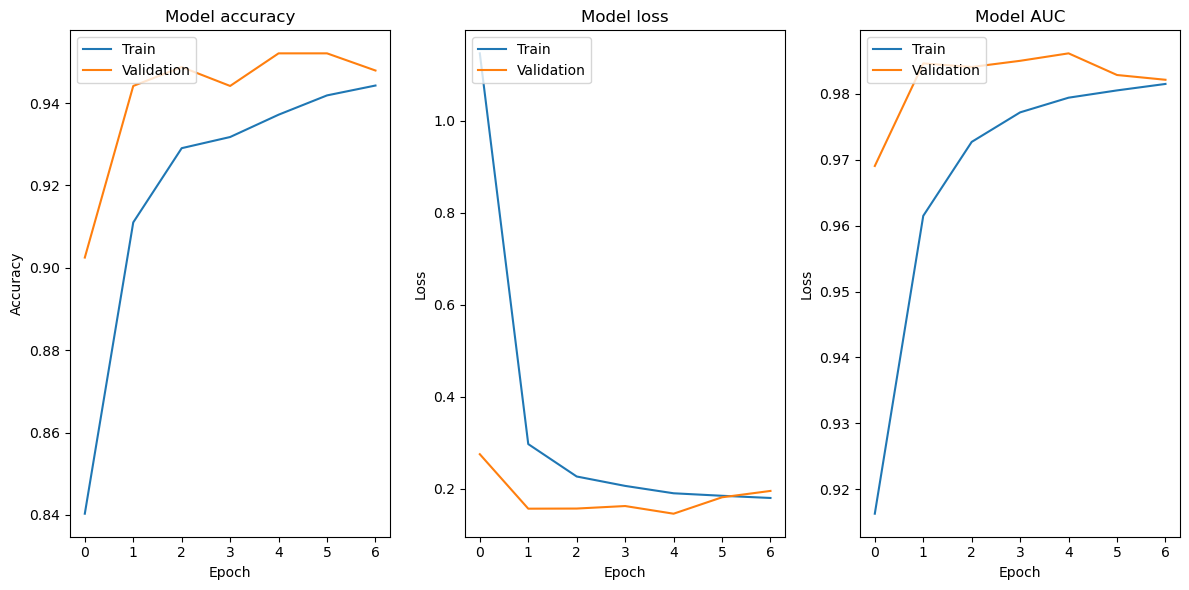

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history_Incptnres.history['accuracy'])
plt.plot(history_Incptnres.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history_Incptnres.history['loss'])
plt.plot(history_Incptnres.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history_Incptnres.history['auc'])
plt.plot(history_Incptnres.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
h_len = len(history_Incptnres.history['val_loss'])
subset = h_len-1

print("Training Scores:")
print("Accuracy:",history_Incptnres.history['accuracy'][subset])
print("Precision:",history_Incptnres.history['precision'][subset])
print("Recall:",history_Incptnres.history['recall'][subset])
print("AUC:",history_Incptnres.history['auc'][subset])

print("")
print("Validation Scores:")
print("Accuracy:",history_Incptnres.history['val_accuracy'][subset])
print("Precision:",history_Incptnres.history['val_precision'][subset])
print("Recall:",history_Incptnres.history['val_recall'][subset])
print("AUC:",history_Incptnres.history['val_auc'][subset])

Training Scores:
Accuracy: 0.9442708492279053
Precision: 0.9486526846885681
Recall: 0.9384970664978027
AUC: 0.981475293636322

Validation Scores:
Accuracy: 0.9479166865348816
Precision: 0.9751924872398376
Recall: 0.9223300814628601
AUC: 0.9821073412895203


75/75 [==============================] - 163s 1s/step


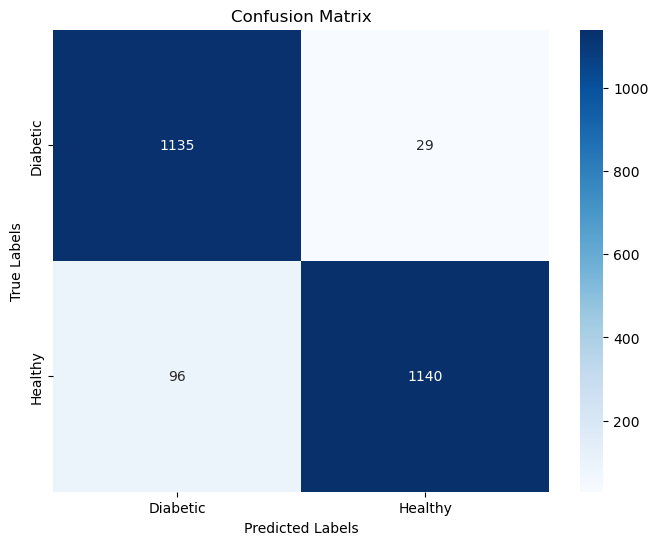

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1164
           1       0.98      0.92      0.95      1236

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.95      0.95      0.95      2400



In [ ]:
# Predict the labels on the validation set
y_pred = model_Incptnres.predict(X_val)

# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert one-hot encoded labels to integers
y_val_int = y_val
y_pred_int = y_pred_binary.squeeze()  # Remove any singleton dimensions

# Calculate the confusion matrix
cm = confusion_matrix(y_val_int, y_pred_int)

# Display the confusion matrix with blue colors
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Diabetic', 'Healthy'], yticklabels=['Diabetic', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(y_val_int, y_pred_int)
print("Classification Report:")
print(report)


# Densenet - Binary Classification

In [ ]:
base_bi_denseN = DenseNet201(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the weights of the pre-trained layers
for layer in base_bi_denseN.layers:
    layer.trainable = False

# Create a new model by adding your layers on top of the pre-trained model
model_bi_densenet = models.Sequential()
model_bi_densenet.add(base_bi_denseN)

# Add your own layers on top of the ResNet50 base
model_bi_densenet.add(Flatten())
model_bi_densenet.add(Dense(512, activation="relu"))
model_bi_densenet.add(Dropout(0.5))
model_bi_densenet.add(Dense(256, activation="relu"))
model_bi_densenet.add(Dropout(0.5))
model_bi_densenet.add(Dense(1, activation="sigmoid"))

# Compile the model
model_bi_densenet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=metrics)

# Print the model summary
model_bi_densenet.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten_12 (Flatten)        (None, 30720)             0         
                                                                 
 dense_32 (Dense)            (None, 512)               15729152  
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 256)               131328    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 1)               

In [ ]:
# Train the model
history_bi_dn = model_bi_densenet.fit(
    X_train, y_train,
    batch_size = 16,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=call)

Epoch 1/10
600/600 [==============================] - 1025s 1s/step - loss: 1.2577 - accuracy: 0.9056 - recall: 0.9077 - precision: 0.9195 - auc: 0.9426 - val_loss: 0.1957 - val_accuracy: 0.9496 - val_recall: 0.9199 - val_precision: 0.9810 - val_auc: 0.9849 - lr: 0.0010
Epoch 2/10
600/600 [==============================] - 695s 1s/step - loss: 0.2519 - accuracy: 0.9409 - recall: 0.9412 - precision: 0.9398 - auc: 0.9775 - val_loss: 0.1352 - val_accuracy: 0.9588 - val_recall: 0.9369 - val_precision: 0.9822 - val_auc: 0.9897 - lr: 0.0010
Epoch 3/10
600/600 [==============================] - 696s 1s/step - loss: 0.1812 - accuracy: 0.9508 - recall: 0.9479 - precision: 0.9527 - auc: 0.9845 - val_loss: 0.1137 - val_accuracy: 0.9596 - val_recall: 0.9531 - val_precision: 0.9680 - val_auc: 0.9924 - lr: 0.0010
Epoch 4/10
600/600 [==============================] - 701s 1s/step - loss: 0.1502 - accuracy: 0.9569 - recall: 0.9526 - precision: 0.9602 - auc: 0.9868 - val_loss: 0.1267 - val_accuracy: 0.

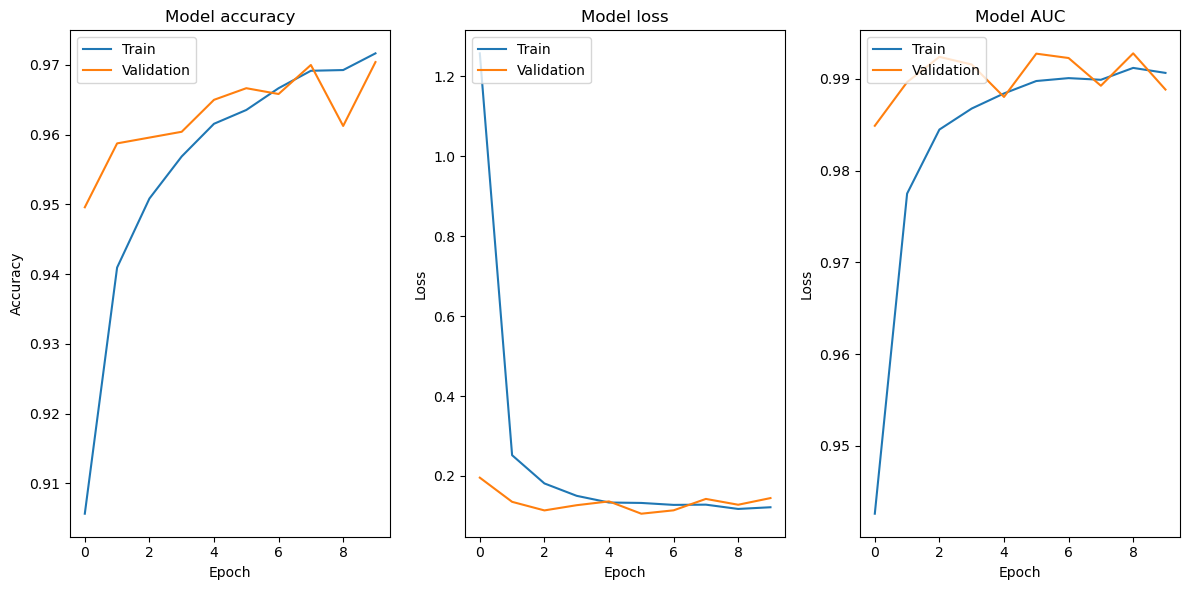

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history_bi_dn.history['accuracy'])
plt.plot(history_bi_dn.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history_bi_dn.history['loss'])
plt.plot(history_bi_dn.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history_bi_dn.history['auc'])
plt.plot(history_bi_dn.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
h_len = len(history_bi_dn.history['val_loss'])
subset = h_len-1

print("Training Scores:")
print("Accuracy:",history_bi_dn.history['accuracy'][subset])
print("Precision:",history_bi_dn.history['precision'][subset])
print("Recall:",history_bi_dn.history['recall'][subset])
print("AUC:",history_bi_dn.history['auc'][subset])

print("")
print("Validation Scores:")
print("Accuracy:",history_bi_dn.history['val_accuracy'][subset])
print("Precision:",history_bi_dn.history['val_precision'][subset])
print("Recall:",history_bi_dn.history['val_recall'][subset])
print("AUC:",history_bi_dn.history['val_auc'][subset])

Training Scores:
Accuracy: 0.971666693687439
Precision: 0.975243330001831
Recall: 0.9674643278121948
AUC: 0.9906549453735352

Validation Scores:
Accuracy: 0.9704166650772095
Precision: 0.9794238805770874
Recall: 0.96278315782547
AUC: 0.9888396263122559


In [ ]:
# Predict the labels on the validation set
y_pred = model_bi_densenet.predict(X_val)

# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert one-hot encoded labels to integers
y_val_int = y_val
y_pred_int = y_pred_binary.squeeze()  # Remove any singleton dimensions

# Calculate the confusion matrix
cm = confusion_matrix(y_val_int, y_pred_int)

# Display the confusion matrix with blue colors
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Diabetic', 'Healthy'], yticklabels=['Diabetic', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(y_val_int, y_pred_int)
print("Classification Report:")
print(report)


# Model Performance

In [ ]:
cnn_accuracy = history_.history['val_accuracy'][subset]
cnn_precision = history_.history['val_precision'][subset]
cnn_recall = history_.history['val_recall'][subset]
cnn_AUC = history_.history['val_auc'][subset]

In [ ]:
vgg_accuracy = history_vgg.history['val_accuracy'][subset]
vgg_precision = history_vgg.history['val_precision'][subset]
vgg_recall = history_vgg.history['val_recall'][subset]
vgg_AUC = history_vgg.history['val_auc'][subset]

In [ ]:
incptn_accuracy = history_Inptn.history['val_accuracy'][subset]
incptn_precision = history_Inptn.history['val_precision'][subset]
incptn_recall = history_Inptn.history['val_recall'][subset]
incptn_AUC = history_Inptn.history['val_auc'][subset]

In [ ]:
resnet_accuracy = history_res.history['val_accuracy'][subset]
resnet_precision = history_res.history['val_precision'][subset]
resnet_recall = history_res.history['val_recall'][subset]
resnet_AUC = history_res.history['val_auc'][subset]

In [ ]:
incptnRes_accuracy = history_Incptnres.history['val_accuracy'][subset]
incptnRes_precision = history_Incptnres.history['val_precision'][subset]
incptnRes_recall = history_Incptnres.history['val_recall'][subset]
incptnRes_AUC = history_Incptnres.history['val_auc'][subset]

In [ ]:
densenet_accuracy = history_dense.history['val_accuracy'][subset]
densenet_precision = history_dense.history['val_precision'][subset]
densenet_recall = history_dense.history['val_recall'][subset]
densenet_AUC = history_dense.history['val_auc'][subset]

In [ ]:
# Define the model scores

model_scores = {
    'Model': ['Custom CNN', 'VGG16', 'Inceptionv3', 'ResNet152V2', 'InceptionResNetV2', 'DenseNet201'],
    'Accuracy': [cnn_accuracy, vgg_accuracy, incptn_accuracy, resnet_accuracy, incptnRes_accuracy, densenet_accuracy],
    'Precision': [cnn_precision, vgg_precision, incptn_precision, resnet_precision, incptnRes_precision, densenet_precision],
    'Recall': [cnn_recall, vgg_recall, incptn_recall, resnet_recall, incptnRes_recall, densenet_recall],
    'AUC': [cnn_AUC, vgg_AUC, incptn_AUC, resnet_AUC, incptnRes_AUC, densenet_AUC]
}

In [ ]:
# Create a DataFrame
models_df = pd.DataFrame(model_scores).set_index('Model')

# Print the DataFrame
print(models_df)

                   Accuracy  Precision  Recall   AUC
Model                                               
Custom CNN             0.96       0.98    0.94  0.99
VGG16                  0.96       0.99    0.94  0.99
Inceptionv3            0.95       0.96    0.95  0.99
ResNet152V2            0.95       0.99    0.94  0.99
InceptionResNetV2      0.95       0.98    0.92  0.98
DenseNet201            0.97       0.98    0.96  0.99


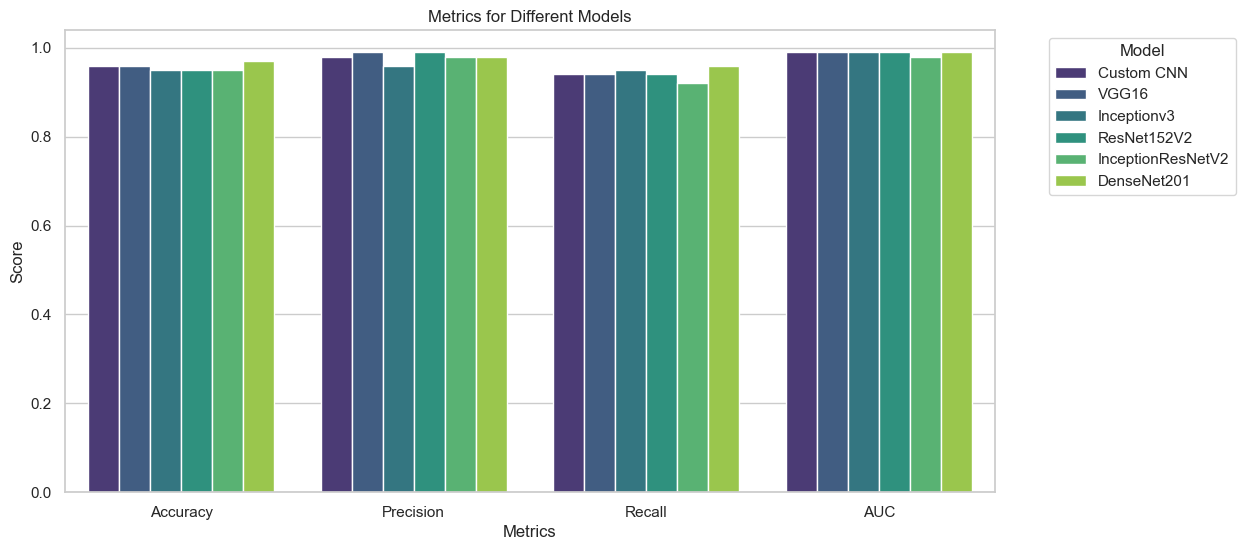

In [ ]:
import seaborn as sns
# Set the style for the plot
sns.set(style="whitegrid")

# Transpose the DataFrame for better plotting
df_transposed = models_df.transpose().reset_index()

# Melt the DataFrame to have 'Optimizer' as a common identifier
melted_df = pd.melt(df_transposed, id_vars=['index'], var_name='Model', value_name='Value')

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='Value', hue='Model', data=melted_df, palette="viridis")

# Customize the plot
plt.title('Metrics for Different Models')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

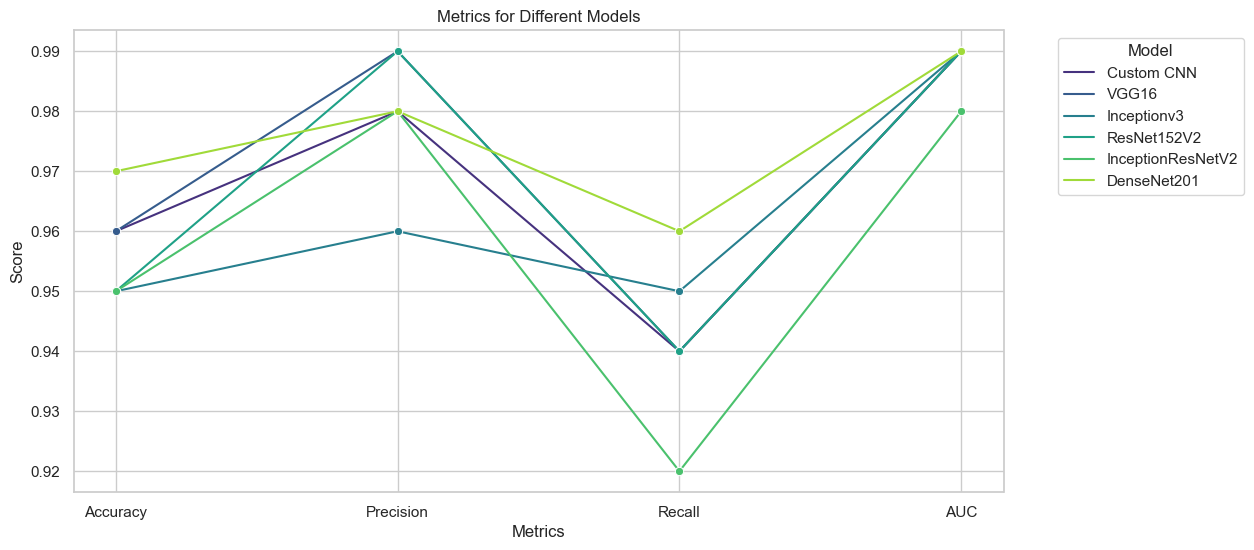

In [ ]:
# Set the style for the plot
sns.set(style="whitegrid")

# Transpose the DataFrame for better plotting
df_transposed = models_df.transpose().reset_index()

# Melt the DataFrame to have 'Optimizer' as a common identifier
melted_df = pd.melt(df_transposed, id_vars=['index'], var_name='Model', value_name='Value')

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='index', y='Value', hue='Model', data=melted_df, palette="viridis", marker='o')

# Customize the plot
plt.title('Metrics for Different Models')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

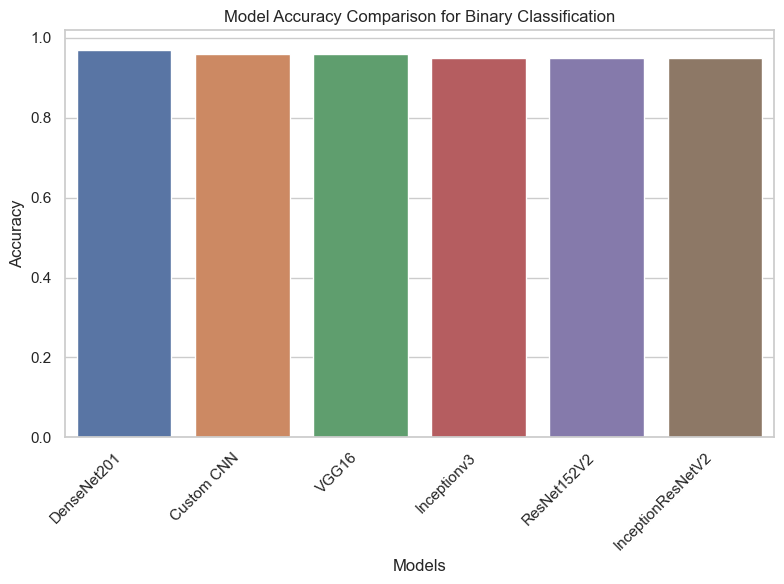

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid")

# Sort the DataFrame by 'Accuracy' in descending order
models_df_sorted = models_df.sort_values(by='Accuracy', ascending=False)

# Plotting
plt.figure(figsize=(8, 6))

# Create a bar plot using Seaborn
sns.barplot(x=models_df_sorted.index, y=models_df_sorted['Accuracy'], order=models_df_sorted.index)

plt.title('Model Accuracy Comparison for Binary Classification')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

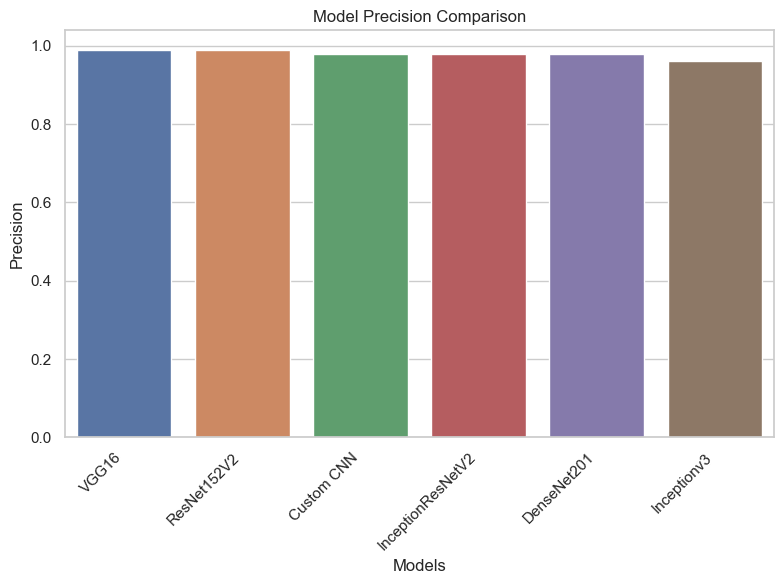

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid")

# Sort the DataFrame by 'Accuracy' in descending order
models_df_sorted = models_df.sort_values(by='Precision', ascending=False)

# Plotting
plt.figure(figsize=(8, 6))

# Create a bar plot using Seaborn
sns.barplot(x=models_df_sorted.index, y=models_df_sorted['Precision'], order=models_df_sorted.index)

plt.title('Model Precision Comparison')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

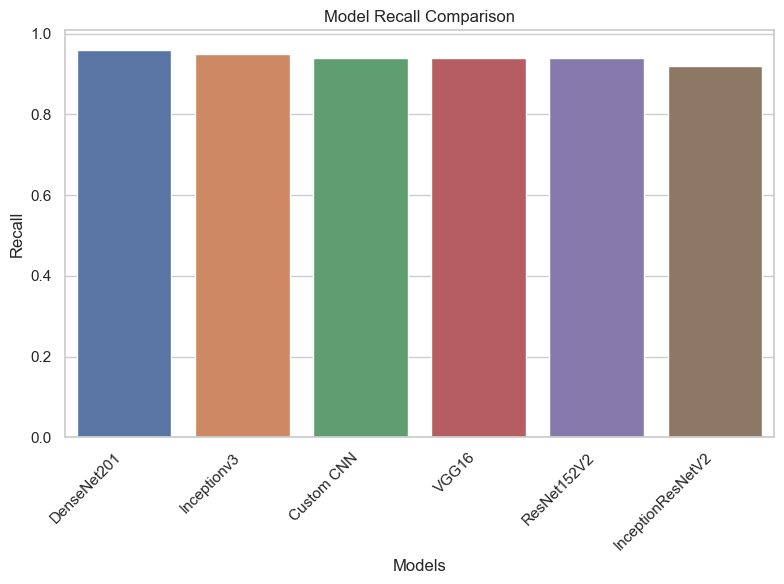

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid")

# Sort the DataFrame by 'Accuracy' in descending order
models_df_sorted = models_df.sort_values(by='Recall', ascending=False)

# Plotting
plt.figure(figsize=(8, 6))

# Create a bar plot using Seaborn
sns.barplot(x=models_df_sorted.index, y=models_df_sorted['Recall'], order=models_df_sorted.index)

plt.title('Model Recall Comparison')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

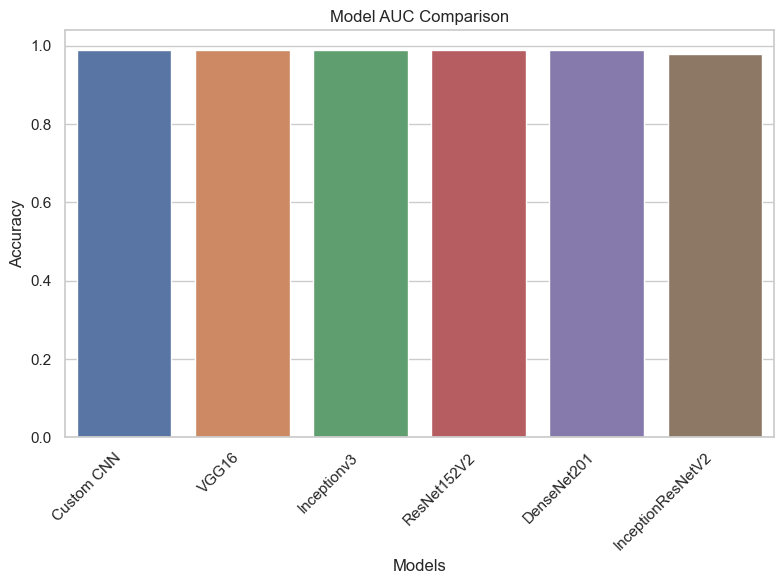

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid")

# Sort the DataFrame by 'Accuracy' in descending order
models_df_sorted = models_df.sort_values(by='AUC', ascending=False)

# Plotting
plt.figure(figsize=(8, 6))

# Create a bar plot using Seaborn
sns.barplot(x=models_df_sorted.index, y=models_df_sorted['AUC'], order=models_df_sorted.index)

plt.title('Model AUC Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

After running the six models, All models performed well on the binary dataset. However, DenseNet201 Model outperformed other models. MOnte Carlo Dropout will be applied to this model, to guage its level of confidence/uncertainty

# Monte Carlo Dropout for Uncertainty Estimation - Binary classification

# Train With Monte Carlo Drop out

In [ ]:
class MCDropout(layers.Dropout):
    def call(self, inputs, training=None):
        if training is None:
            training = K.learning_phase()

        if 0 < self.rate < 1:
            noise_shape = self._get_noise_shape(inputs)
            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape, seed=self.seed) * (1 - self.rate)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

In [ ]:
# Replace layers.Dropout with MCDropout in your model
model_bi_dn_MC = models.Sequential()
model_bi_dn_MC.add(base_bi_denseN)
model_bi_dn_MC.add(layers.GlobalAveragePooling2D())
model_bi_dn_MC.add(layers.BatchNormalization())
model_bi_dn_MC.add(layers.Dense(512, activation='relu'))

model_bi_dn_MC.add(layers.BatchNormalization())
model_bi_dn_MC.add(MCDropout(0.5))  # Replace Dropout with MCDropout
model_bi_dn_MC.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_bi_dn_MC.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=metrics)

#print the summary
model_bi_dn_MC.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization_598 (B  (None, 1920)              7680      
 atchNormalization)                                              
                                                                 
 dense_35 (Dense)            (None, 512)               983552    
                                                                 
 batch_normalization_599 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                     

In [ ]:
# Train the model
history_bi_dn_MC = model_bi_dn_MC.fit(
    X_train, y_train,
    batch_size = 16,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=call)


Epoch 1/10
600/600 [==============================] - 1888s 3s/step - loss: 0.1408 - accuracy: 0.9497 - recall: 0.9492 - precision: 0.9581 - auc: 0.9871 - val_loss: 0.1016 - val_accuracy: 0.9750 - val_recall: 0.9668 - val_precision: 0.9843 - val_auc: 0.9928 - lr: 0.0010
Epoch 2/10
600/600 [==============================] - 1673s 3s/step - loss: 0.1044 - accuracy: 0.9620 - recall: 0.9595 - precision: 0.9637 - auc: 0.9925 - val_loss: 0.1106 - val_accuracy: 0.9746 - val_recall: 0.9636 - val_precision: 0.9867 - val_auc: 0.9923 - lr: 0.0010
Epoch 3/10
600/600 [==============================] - 1812s 3s/step - loss: 0.0949 - accuracy: 0.9660 - recall: 0.9603 - precision: 0.9709 - auc: 0.9935 - val_loss: 0.0884 - val_accuracy: 0.9762 - val_recall: 0.9725 - val_precision: 0.9812 - val_auc: 0.9943 - lr: 0.0010
Epoch 4/10
600/600 [==============================] - 2052s 3s/step - loss: 0.0812 - accuracy: 0.9711 - recall: 0.9660 - precision: 0.9756 - auc: 0.9948 - val_loss: 0.0969 - val_accuracy:

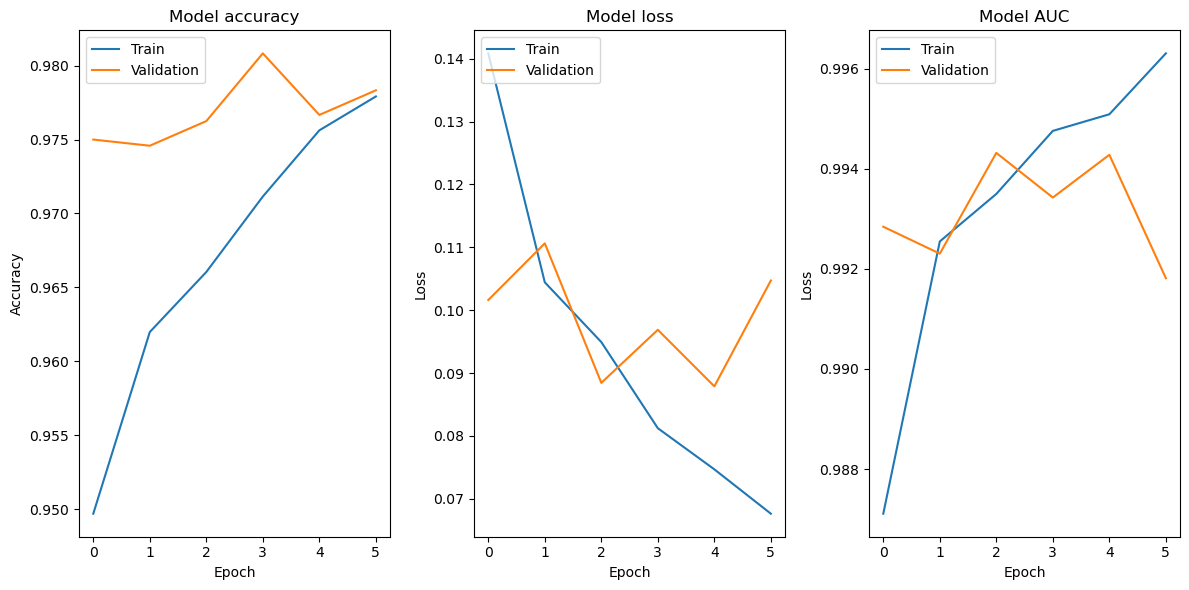

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history_bi_dn_MC.history['accuracy'])
plt.plot(history_bi_dn_MC.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history_bi_dn_MC.history['loss'])
plt.plot(history_bi_dn_MC.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history_bi_dn_MC.history['auc'])
plt.plot(history_bi_dn_MC.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
h_len = len(history_bi_dn_MC.history['val_loss'])
subset = h_len-1

print("Training Scores:")
print("Accuracy:",history_bi_dn_MC.history['accuracy'][subset])
print("Precision:",history_bi_dn_MC.history['precision'][subset])
print("Recall:",history_bi_dn_MC.history['recall'][subset])
print("AUC:",history_bi_dn_MC.history['auc'][subset])

print("")
print("Validation Scores:")
print("Accuracy:",history_bi_dn_MC.history['val_accuracy'][subset])
print("Precision:",history_bi_dn_MC.history['val_precision'][subset])
print("Recall:",history_bi_dn_MC.history['val_recall'][subset])
print("AUC:",history_bi_dn_MC.history['val_auc'][subset])

Training Scores:
Accuracy: 0.9779166579246521
Precision: 0.9785534143447876
Recall: 0.9769101738929749
AUC: 0.9963043332099915

Validation Scores:
Accuracy: 0.9783333539962769
Precision: 0.983660101890564
Recall: 0.9741100072860718
AUC: 0.991811990737915


75/75 [==============================] - 221s 3s/step


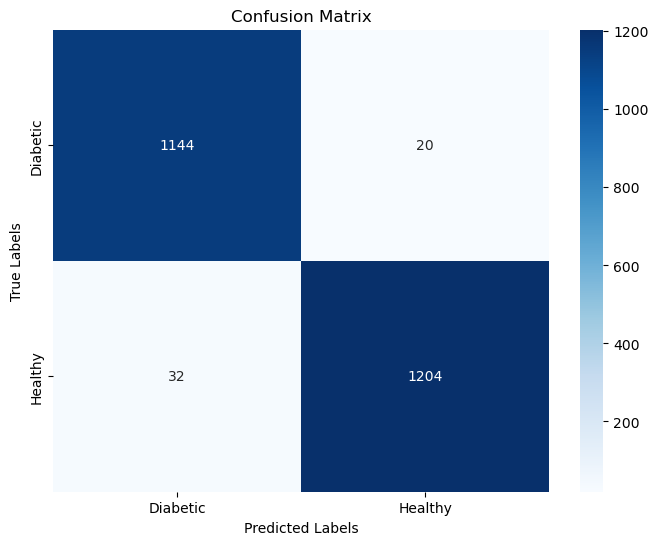

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1164
           1       0.98      0.97      0.98      1236

    accuracy                           0.98      2400
   macro avg       0.98      0.98      0.98      2400
weighted avg       0.98      0.98      0.98      2400



In [ ]:
# Predict the labels on the validation set
y_pred = model_bi_dn_MC.predict(X_val)

# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert one-hot encoded labels to integers
y_val_int = y_val
y_pred_int = y_pred_binary.squeeze()  # Remove any singleton dimensions

# Calculate the confusion matrix
cm = confusion_matrix(y_val_int, y_pred_int)

# Display the confusion matrix with blue colors
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Diabetic', 'Healthy'], yticklabels=['Diabetic', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(y_val_int, y_pred_int)
print("Classification Report:")
print(report)


The integration of Monte Carlo improved the DenseNet model  by 1%

# Monte Carlo Dropout during testing

In [ ]:
# Function to run Monte Carlo Dropout during testing
def run_monte_carlo_dropout(model, X_val_data, num_samples=10):
    # List to store predictions for each sample
    predictions = []

    for _ in range(num_samples):
        # Predict using the model with dropout
        predictions.append(model.predict(X_val_data))

    # Stack the predictions to obtain a 3D array (num_samples, num_instances, num_classes)
    predictions = np.stack(predictions, axis=0)

    # Calculate mean and standard deviation across the samples
    mean_prediction = np.mean(predictions, axis=0)
    uncertainty = np.std(predictions, axis=0)

    return mean_prediction, uncertainty

In [ ]:
# call function run_monte_carlo_dropout
mean_pred, uncertainty = run_monte_carlo_dropout(model_bi_dn_MC, X_val, num_samples=10)

75/75 [==============================] - 293s 4s/step


In [ ]:
mean_pred

array([[1.0000000e+00],
       [2.2388056e-07],
       [9.9999964e-01],
       ...,
       [9.9999917e-01],
       [9.9999106e-01],
       [1.0000000e+00]], dtype=float32)

In [ ]:
uncertainty

array([[0.0000000e+00],
       [0.0000000e+00],
       [5.9604645e-08],
       ...,
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00]], dtype=float32)

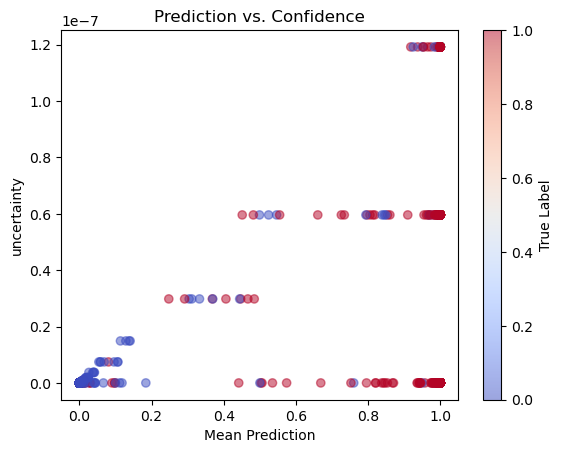

In [ ]:
# Scatter plot of prediction vs. confidence with color map based on true labels
plt.scatter(mean_pred, uncertainty, c=y_val, cmap='coolwarm', alpha=0.5)
plt.colorbar(label='True Label')
plt.xlabel('Mean Prediction')
plt.ylabel('uncertainty')
plt.title('Prediction vs. Confidence')
plt.show()

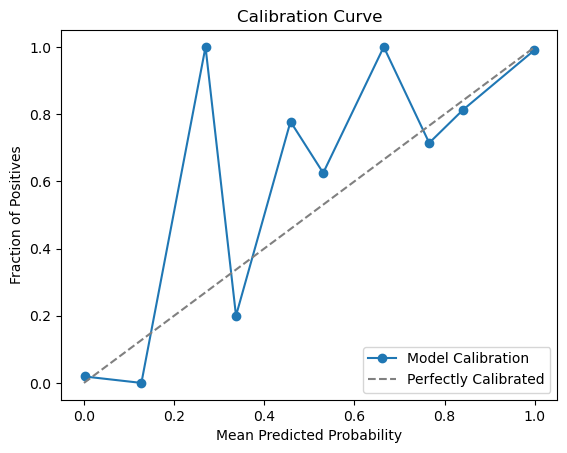

In [ ]:
from sklearn.calibration import calibration_curve

# Calibration curve
prob_true, prob_pred = calibration_curve(y_val, mean_pred, n_bins=10)

# Plot the calibration curve
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

The visualized calibration curve shows that the model is averagely confident in its prediction

Now that the model's confidence level has been estimated, i will apply LIME to the model, to explain the features that influence the model's prediction

# Model Explainability with LIME - Binary classification

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Choose a specific sample index for explanation
sample_index = np.random.choice(len(X_val))  # Randomly choose an index from your validation set

# Get the image and true class for the selected sample
selected_image = X_val[sample_index]
true_class = np.argmax(y_val[sample_index])

# Create the LimeImageExplainer
explainer = lime_image.LimeImageExplainer()


In [ ]:
# Explain the model's prediction for the selected image
explanation = explainer.explain_instance(selected_image, model_bi_dn_MC.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


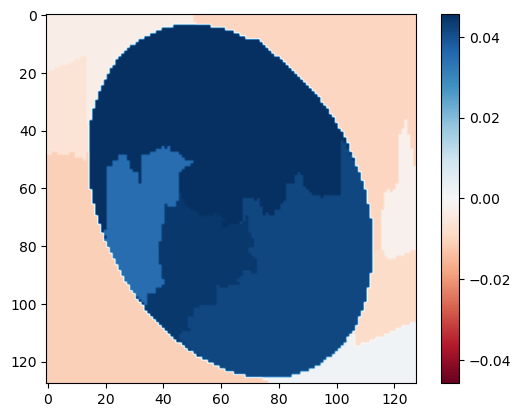

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

(-0.5, 127.5, 127.5, -0.5)

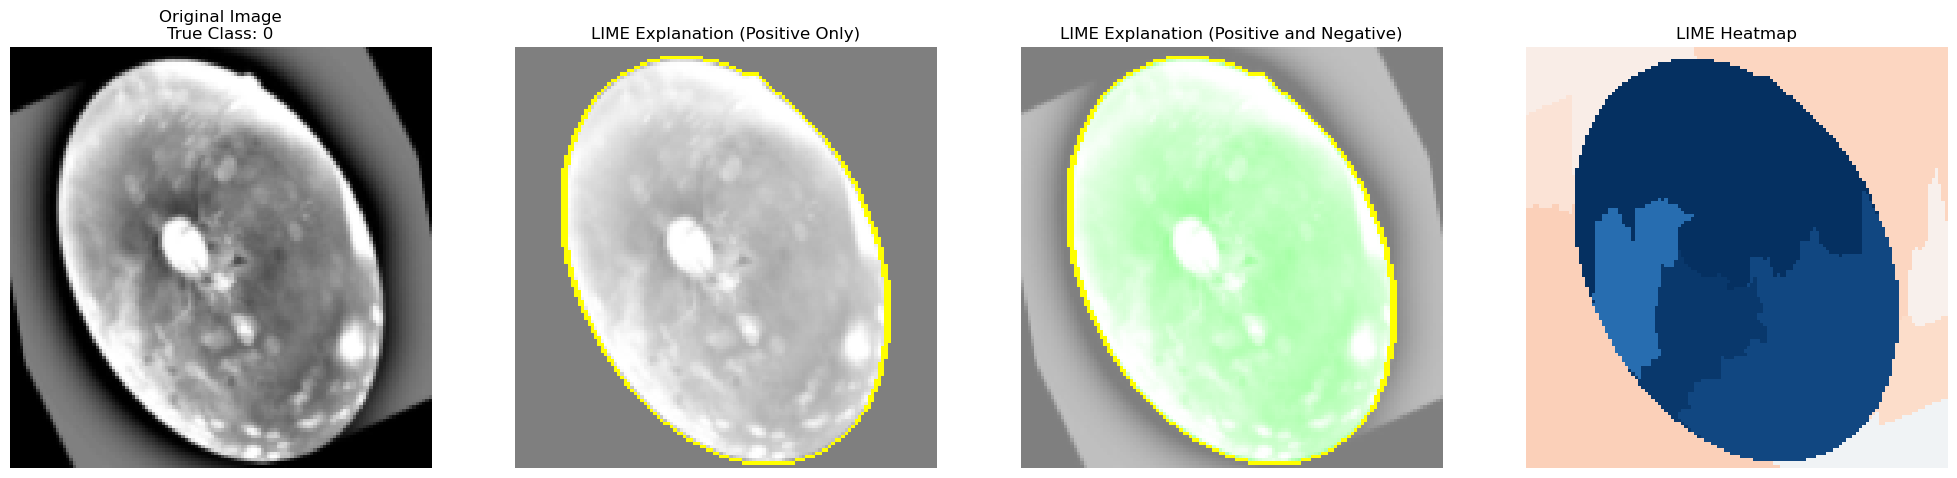

In [ ]:
# Display the original image and the LIME explanation side by side
fig, axes = plt.subplots(1, 4, figsize=(25, 6))

# Display the original image
axes[0].imshow(selected_image)
axes[0].set_title(f"Original Image\nTrue Class: {true_class}")
axes[0].axis('off')

# Display the LIME explanation (Positive Only)
lime_img_pos, mask_pos = explanation.get_image_and_mask(true_class, positive_only=True, num_features=5, hide_rest=True)
axes[1].imshow(mark_boundaries(lime_img_pos / 2 + 0.5, mask_pos))
axes[1].set_title("LIME Explanation (Positive Only)")
axes[1].axis('off')

# Display the LIME explanation (Positive and Negative)
lime_img_all, mask_all = explanation.get_image_and_mask(true_class, positive_only=False, num_features=5, hide_rest=False)
axes[2].imshow(mark_boundaries(lime_img_all / 2 + 0.5, mask_all))
axes[2].set_title("LIME Explanation (Positive and Negative)")
axes[2].axis('off')

# Display the LIME heatmap
axes[3].imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
axes[3].set_title("LIME Heatmap")
axes[3].axis('off')

# Conclusion


This project utilized Deep Learning models cnn, VGG16, InceptionV3 , ResNet15V2, InceptionResNetV2 and DenseNet201 to detect if retinal image id Diabetic or Healthy. DenseNet model achieved the highest accuracy of 97%. The integration of Monte Carlo Dropout Model further improved DenseNet model by 1%.
